# Analyzing @netanyahu Tweets using Time series & NLP techniques

By Ori Rosenthal

In [1]:
import pandas as pd
import numpy as np
import twint
import requests
import string
import emoji
import re
import datetime as dt
from wordcloud import WordCloud, STOPWORDS
from bidi.algorithm import get_display
from pygooglenews import GoogleNews
from googletrans import Translator
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, WordNetLemmatizer
from nltk.probability import FreqDist
from textblob import TextBlob
from gensim.corpora import Dictionary
from gensim import matutils, models
from gsdmm import MovieGroupProcess
import scipy.sparse
import spacy
from spacy import displacy
import spacy_udpipe
from collections import Counter
import en_core_web_sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

# plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# !twint -u netanyahu --since 2008-01-01 -o all_netanyahu_tweets.csv --csv
df = pd.read_csv('all_netanyahu_tweets.csv', sep='\t')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7206 entries, 0 to 7205
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7206 non-null   int64  
 1   conversation_id  7206 non-null   int64  
 2   created_at       7206 non-null   object 
 3   date             7206 non-null   object 
 4   time             7206 non-null   object 
 5   timezone         7206 non-null   int64  
 6   user_id          7206 non-null   int64  
 7   username         7206 non-null   object 
 8   name             7206 non-null   object 
 9   place            0 non-null      float64
 10  tweet            7206 non-null   object 
 11  language         7206 non-null   object 
 12  mentions         7206 non-null   object 
 13  urls             7206 non-null   object 
 14  photos           7206 non-null   object 
 15  replies_count    7206 non-null   int64  
 16  retweets_count   7206 non-null   int64  
 17  likes_count   

In [4]:
# dropping columns according to NAN percentage threshold (keep all those columns with 70% Non-na values).
df.dropna(axis=1, thresh = int(0.7*df.shape[0]), inplace=True)
# converting columns (date,time) into datetime format, setting date as index and droppiong irrelevant features. 
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'])
df.set_index(df['date'], inplace=True)
df = df.sort_index()
df.drop(['id','conversation_id','username','name','created_at','timezone','cashtags'],axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7206 entries, 2008-10-30 to 2021-03-24
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            7206 non-null   datetime64[ns]
 1   time            7206 non-null   datetime64[ns]
 2   user_id         7206 non-null   int64         
 3   tweet           7206 non-null   object        
 4   language        7206 non-null   object        
 5   mentions        7206 non-null   object        
 6   urls            7206 non-null   object        
 7   photos          7206 non-null   object        
 8   replies_count   7206 non-null   int64         
 9   retweets_count  7206 non-null   int64         
 10  likes_count     7206 non-null   int64         
 11  hashtags        7206 non-null   object        
 12  link            7206 non-null   object        
 13  retweet         7206 non-null   bool          
 14  video           7206 non-null   int64 

In [6]:
df.head()

date                time   user_id  \
date                                                  
2008-10-30 2008-10-30 2021-04-05 08:45:22  17061263   
2008-11-02 2008-11-02 2021-04-05 13:47:49  17061263   
2008-11-03 2008-11-03 2021-04-05 14:22:06  17061263   
2008-11-05 2008-11-05 2021-04-05 10:13:49  17061263   
2008-11-06 2008-11-06 2021-04-05 14:04:17  17061263   

                                                        tweet language  \
date                                                                     
2008-10-30                     ◊î◊ô◊ï◊ù ◊ë◊¢◊®◊ë ◊õ◊†◊°◊ô◊ù ◊ë◊®◊û◊ú◊î ◊ï◊ë◊í◊ë◊¢◊™◊ô◊ù       iw   
2008-11-02  ◊†◊õ◊†◊° ◊¢◊õ◊©◊ô◊ï ◊ú◊û◊°◊ô◊ë◊™ ◊¢◊ô◊™◊ï◊†◊ê◊ô◊ù ◊¢◊ù ◊û◊ô◊®◊ô ◊®◊í◊ë- ◊û◊¶◊ò◊®◊§◊™...       iw   
2008-11-03                                  ◊ë◊ô◊©◊ô◊ë◊™ ◊°◊ô◊¢◊î ◊ë◊õ◊†◊°◊™       iw   
2008-11-05  ◊î◊¢◊ú◊ô◊†◊ï ◊¢◊û◊ï◊ì ◊™◊ï◊û◊õ◊ô◊ù ◊ë◊§◊ô◊ô◊°◊ë◊ï◊ß:  http://tinyurl.c...       iw   
2008-11-06                            ◊¢◊ï◊ë◊ì◊ô◊ù ◊ë◊û◊®◊• ◊¢◊ú ◊ê◊™◊® ◊ó◊ì◊©.       iw   

           mentions urls photos  replies_count  retweets_count  likes_count  \
date                                                                          
2008-10-30       []   []     []             12               8           32   
2008-11-02       []   []     []             34               8          131   
2008-11-03       []   []     []              0               0            1   
2008-11-05       []   []     []              0               0            1   
2008-11-06       []   []     []              0               0            1   

           hashtags                                            link  retweet  \
date                                                                           
2008-10-30       []  https://twitter.com/netanyahu/status/981805657    False   
2008-11-02       []  https://twitter.com/netanyahu/status/986233276    False   
2008-11-03       []  https://twitter.com/netanyahu/status/987513960    False   
2008-11-05       []  https://twitter.com/netanyahu/status/991348948    False   
2008-11-06       []  https://twitter.com/netanyahu/status/993157576    False   

            video reply_to  
date                        
2008-10-30      0       []  
2008-11-02      0       []  
2008-11-03      0       []  
2008-11-05      0       []  
2008-11-06      0       []

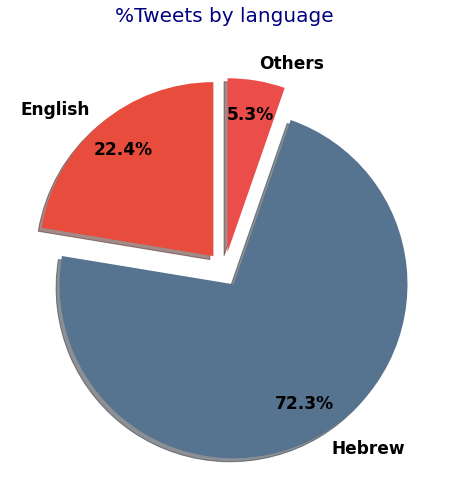

In [7]:
# number of tweets by language
l_pie = (
     df['language'].value_counts(normalize=True)
    .to_frame()
    .reset_index()
    .rename(columns={'index':'l_code','language':'percentage'})
    .replace({'l_code':{'iw':'Hebrew','en':'English'}})
    .assign(language = lambda x: np.select([x['percentage'] > 0.05,x['percentage']<=0.05],[x['l_code'], "Others"]))
    .groupby('language')['percentage'].sum())
          
fig1, ax = plt.subplots(figsize=(8,8))
ax.pie(l_pie, explode=(0.1,0.1,0.1),autopct='%1.1f%%', labels=l_pie.index,colors = [ '#e74c3c', '#56738f','#eb4d4b'],
       shadow=True, startangle=90,pctdistance=0.8, labeldistance=1.1, textprops={'fontsize': 17, 'weight':'bold'});
ax.set_title("%Tweets by language", size=20,color='navy',pad=30);

In [8]:
total_ndays = (df.date.max() - df.date.min()).days
print(f"Total number of days: {total_ndays}")
print(f'Dataset First day: {df.index[0].date()}')
print(f'Dataset Last day: {df.index[-1].date()}')
print(f"The average number of tweets sent per day: {round(len(df)/total_ndays,1)}")
print(f"Number of Hebrew tweets per day on average: {round(len(df[df.language == 'iw'])/total_ndays,1)}")
print(f"Number of English tweets per day on average: {round(len(df[df.language == 'en'])/total_ndays,1)}")

Total number of days: 4528
Dataset First day: 2008-10-30
Dataset Last day: 2021-03-24
The average number of tweets sent per day: 1.6
Number of Hebrew tweets per day on average: 1.2
Number of English tweets per day on average: 0.4


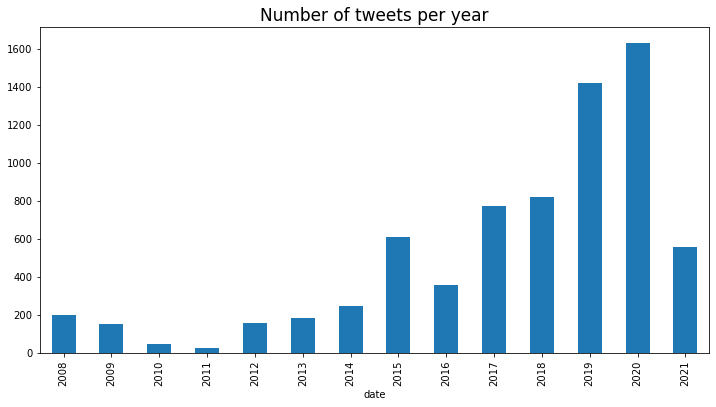

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
yearly_tweets = df.resample('Y')['tweet'].count()
yearly_tweets.index = yearly_tweets.index.year
yearly_tweets.plot(kind='bar');
plt.title('Number of tweets per year', size=17);

#### Number of words/characters in a tweet
* The distribution's midian value is represented by vertical dashed lines.

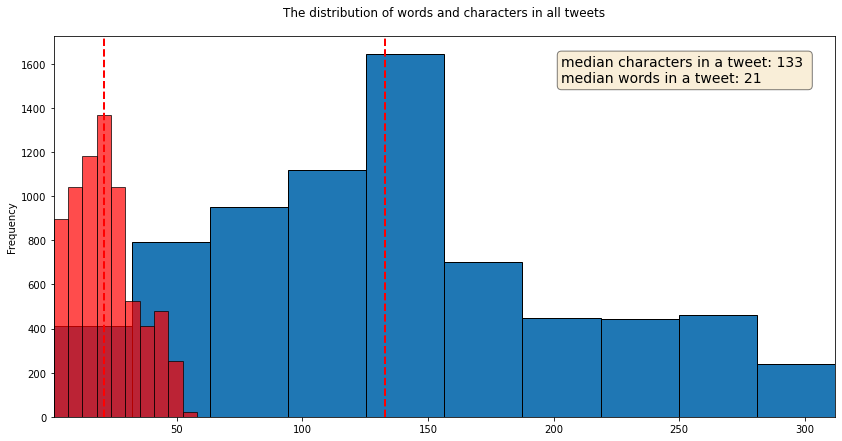

In [10]:
df['tweet_len'] = df['tweet'].map(lambda x: len(x))
df['tweet_n_words'] = df['tweet'].map(lambda x: len(x.split()))
fig, ax = plt.subplots(figsize=(14,7))
df.tweet_len.plot(kind='hist',edgecolor="k");
df.tweet_n_words.plot(kind='hist',color='r',edgecolor="k", alpha=0.7);
plt.axvline(df['tweet_len'].median(), ls = '--',color='r',lw=2);
plt.axvline(df['tweet_n_words'].median(), ls = '--',color='r',lw=2);
textstr = (f"median characters in a tweet: {round(df['tweet_len'].median())} \n"
           f"median words in a tweet: {round(df['tweet_n_words'].median())}")  
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5,edgecolor='black')
plt.text(0.65, 0.95, textstr, fontsize=14,transform=ax.transAxes,verticalalignment='top', bbox=props)
plt.title("The distribution of words and characters in all tweets", pad=20);plt.margins(x=0);

#### Likes, replies and retweets count statistics
* The distribution's midian value is represented by vertical dashed lines.

In [11]:
def plot_counts_statistics(x):
    # To improve visualization and reflection of reality, outlairs were removed using np.clip.
    up_limit = df[x].mean() + df[x].std() * 3
    fig, ax = plt.subplots(figsize=(10,6))
    plt.hist(np.clip(df[x], 0, up_limit), bins=20,edgecolor="k")
    plt.axvline(df[x].median(),ls = '--', color='r',lw=2);
    textstr = r'median=%.f' % (df[x].median().round())
    props = dict(boxstyle='round', facecolor='wheat',edgecolor='black', alpha=0.5)
    plt.text(0.8, 0.95, textstr, fontsize=14,transform=ax.transAxes,verticalalignment='top', bbox=props)
    plt.title(f'{x.capitalize()} distribution', size=15)
    plt.margins(x=0);    

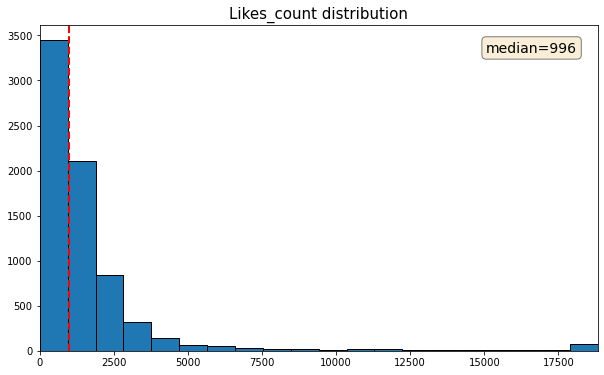

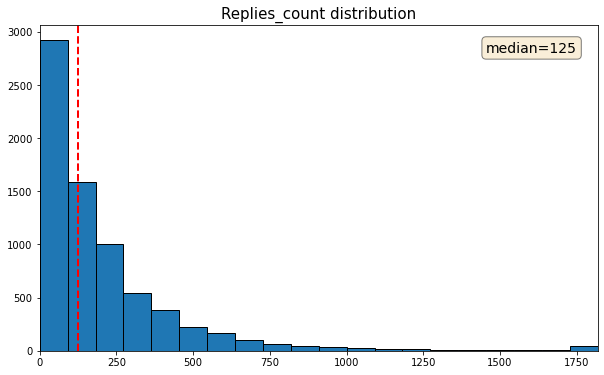

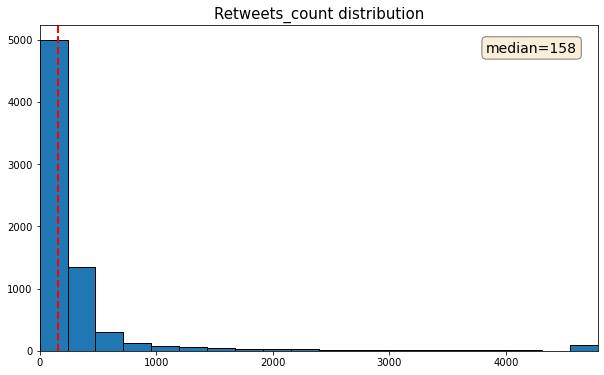

In [12]:
count_statitics= ['likes_count', 'replies_count', 'retweets_count']
for i in count_statitics:
    plot_counts_statistics(i)

#### kernel density estimate (KDE) plots to visualize the distribution of likes count for tweets with and without photos/videos/urls/mentions
* The distribution's midian value is represented by vertical lines.

In [13]:
def plot_targeted_feature(x, y):
    """
    Return KDE plots of two count ditrebutions. with and without x.
    """
    
    up_limit = df[y].mean() + df[y].std() * 2
    fig, ax = plt.subplots(figsize=(12,6))
    if x =='video':
        x1 = df[df[x] ==0][y]
        x2 = df[df[x] ==1][y]
    else:
        x1 = df[df[x] =="[]"][y]
        x2 = df[df[x] !="[]"][y]
    sns.set(font_scale = 1.1)
    sns.kdeplot(np.clip(x1, 0, up_limit), color="#e74c3c", shade=True, label =f'without {x}', alpha=0.6)
    sns.kdeplot(np.clip(x2, 0, up_limit), color="#34495e", shade=True, label=f'with {x}', alpha=0.6)
    plt.axvline(x1.median(), color='#e74c3c');
    plt.axvline(x2.median(), color='#34495e');
    plt.title(f'Tweets with {x.capitalize()} - likes count distribution', size=15, fontweight='bold')
    plt.margins(x=0); plt.legend();

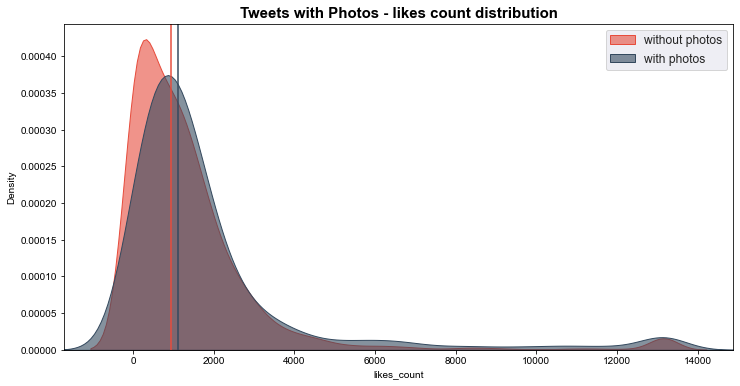

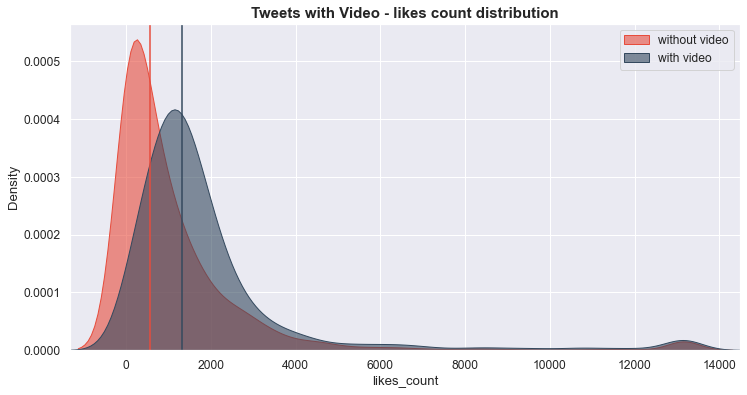

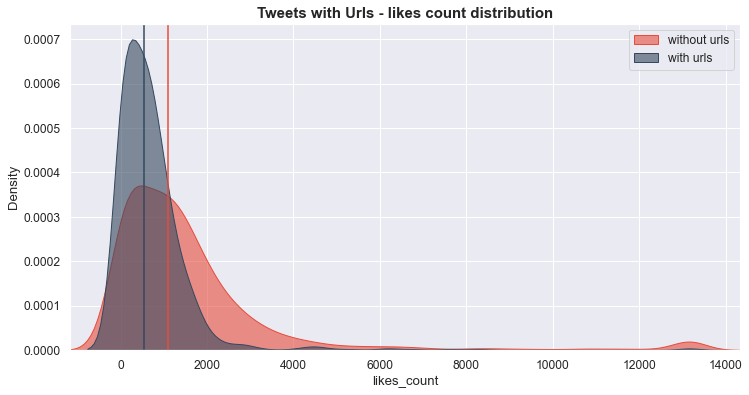

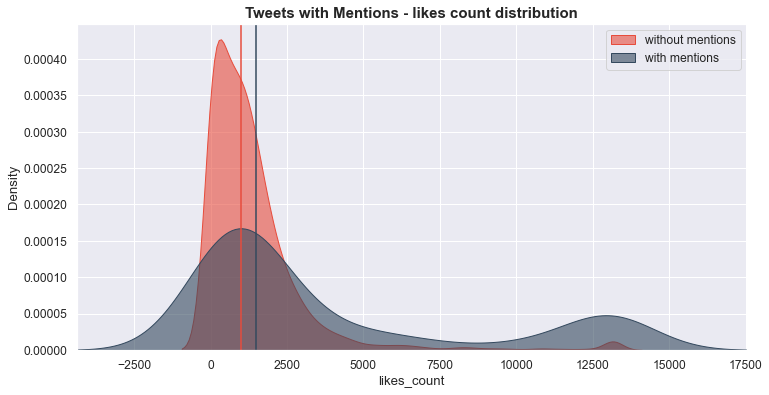

In [14]:
count_statitics2= ['photos', 'video', 'urls', 'mentions']
for i in count_statitics2:
    plot_targeted_feature(i,'likes_count')

<bold><font color='#34495e'>**When a video or mentions is added to a tweet, the number of likes increases,  
when an image is added, the number of likes stays the same, and when a URL included, the number of likes falls below the norm.** </font></bold>

### Correlation between retweets, replies and likes 

In [15]:
df[['replies_count','retweets_count','likes_count']].corr().round(2)

replies_count  retweets_count  likes_count
replies_count            1.00            0.75         0.73
retweets_count           0.75            1.00         0.91
likes_count              0.73            0.91         1.00

### Tweets by time of the day

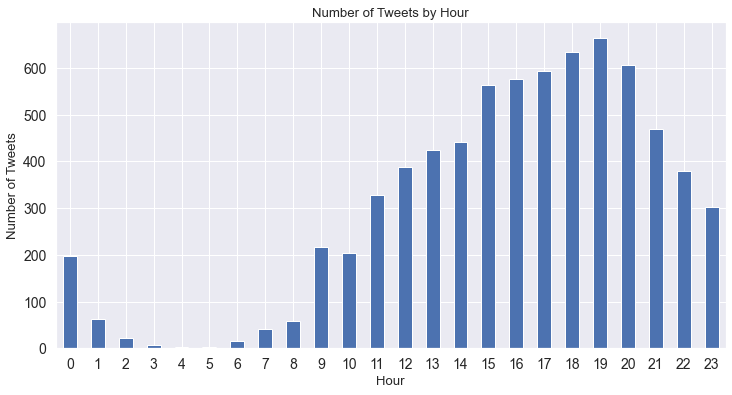

In [16]:
title = 'Number of Tweets by Hour'
df.tweet.groupby(df.time.dt.hour).count().plot(figsize=(12,6), fontsize=14, kind='bar', rot=0, title=title)
plt.xlabel('Hour')
plt.ylabel('Number of Tweets');

### Tweets by day of the week

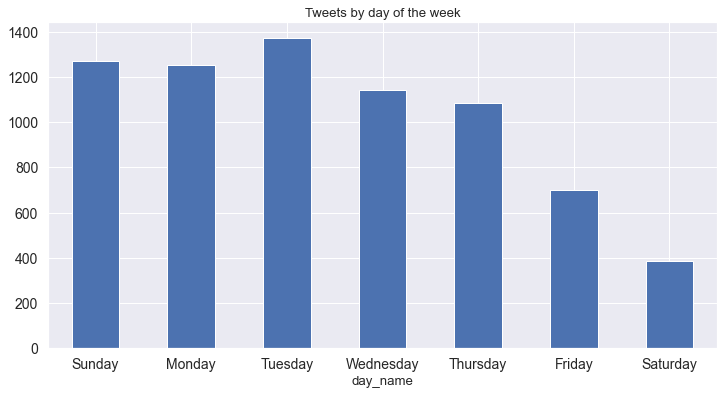

In [17]:
df['day_name'] = df["date"].dt.day_name()
cats= ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
df_weekday = df.tweet.groupby(df['day_name']).count().reindex(cats)
title = 'Tweets by day of the week'
df_weekday.plot(figsize=(12,6), fontsize=14, kind='bar', rot=0, title=title);

####  <font color='#34495e'> As we can see, the largest number of tweets is in the evening, as well as on the weekends the number of tweets is the lowest because the prime minister does not tweet from the beginning to the end of Shabbat in order to respect religious feelings. </font>

### Top Mentions


4.91% of Benjamin Netanyahu tweets, contains mention of another username.


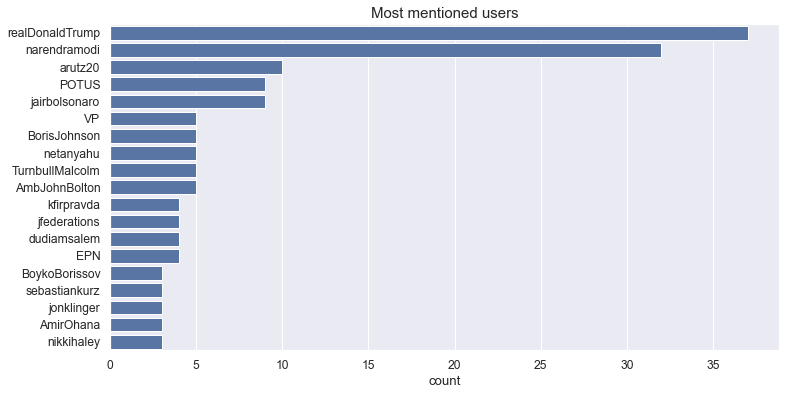

In [18]:
df['mention_user'] = df.tweet.str.findall(r'(?<![@\w])@(\w{1,25})').apply(','.join)
mentions_count = (df.mention_user.value_counts()[1:20]
                  .to_frame().reset_index()
                  .rename(columns={"index": "mention_user", "mention_user": "count"}))

print(f'\n{round(np.where(df["mentions"] !="[]",1,0).sum()/len(df)*100,2)}% of Benjamin Netanyahu tweets,'\
      f' contains mention of another username.')
plt.figure(figsize=(12,6))
sns.barplot(x=mentions_count['count'],y=mentions_count['mention_user'], color='b');
plt.title("Most mentioned users", size=15);plt.ylabel(''); 

### <u>Most liked tweets</u>

In [19]:
pd.set_option('display.max_colwidth', None)
likesorder=df[['likes_count','tweet']].sort_values(by=['likes_count'],ascending=False)
likesorder.head(5)

likes_count  \
date                      
2019-05-23       164267   
2020-08-14       158666   
2019-08-15       156992   
2019-05-23       116539   
2019-06-12        92766   

                                                                                                                                                                                                                                                                                                  tweet  
date                                                                                                                                                                                                                                                                                                     
2019-05-23              ‡§Æ‡•á‡§∞‡•á ‡§¶‡•ã‡§∏‡•ç‡§§ @narendramodi ‡§Ü‡§™‡§ï‡•á ‡§™‡•ç‡§∞‡§≠‡§æ‡§µ‡§∂‡§æ‡§≤‡•Ä ‡§ö‡•Å‡§®‡§æ‡§µ‡•Ä ‡§ú‡•Ä‡§§ ‡§™‡§∞ ‡§π‡§æ‡§∞‡•ç‡§¶‡§ø‡§ï ‡§¨‡§ß‡§æ‡§à! ‡§Ø‡•á ‡§ö‡•Å‡§®‡§æ‡§µ‡•Ä ‡§®‡§§‡•Ä‡§ú‡•á ‡§è‡§ï ‡§¨‡§æ‡§∞ ‡§´‡§ø‡§∞ ‡§¶‡•Å‡§®‡§ø‡§Ø‡§æ ‡§ï‡•á ‡§∏‡§¨‡§∏‡•á ‡§¨‡§°‡§º‡•á ‡§≤‡•ã‡§ï‡§§‡§Ç‡§§‡•ç‡§∞ ‡§Æ‡•á‡§Ç ‡§Ü‡§™‡§ï‡•á ‡§®‡•á‡§§‡•É‡§§‡•ç‡§µ ‡§ï‡•ã ‡§∏‡§æ‡§¨‡§ø‡§§ ‡§ï‡§∞‡§§‡•á ‡§π‡•à‡§Ç‡•§  ‡§π‡§Æ ‡§∏‡§æ‡§• ‡§Æ‡§ø‡§≤‡§ï‡§∞ ‡§≠‡§æ‡§∞‡§§ ‡§î‡§∞ ‡§á‡§ú‡§º‡§∞‡§æ‡§á‡§≤ ‡§ï‡•á ‡§¨‡•Ä‡§ö ‡§ò‡§®‡§ø‡§∑‡•ç‡§ü ‡§Æ‡§ø‡§§‡•ç‡§∞‡§§‡§æ ‡§ï‡•ã ‡§Æ‡§ú‡§¨‡•Ç‡§§ ‡§ï‡§∞‡§®‡§æ ‡§ú‡§æ‡§∞‡•Ä ‡§∞‡§ñ‡•á‡§Ç‡§ó‡•á ‡•§ ‡§¨‡§π‡•Å‡§§ ‡§¨‡§¢‡§º‡§ø‡§Ø‡§æ, ‡§Æ‡•á‡§∞‡•á ‡§¶‡•ã‡§∏‡•ç‡§§  üáÆüá±ü§ùüáÆüá≥  
2020-08-14                                                         Wishing my very good friend @PMOIndia @narendramodi and all the people of #IncredibleIndia a joyful #IndiaIndependenceDay¬†.  You have so much to be proud of.  ‡§∏‡•ç‡§µ‡§§‡§Ç‡§§‡•ç‡§∞‡§§‡§æ ‡§¶‡§ø‡§µ‡§∏ ‡§ï‡•Ä ‡§π‡§æ‡§∞‡•ç‡§¶‡§ø‡§ï ‡§∂‡•Å‡§≠‡§ï‡§æ‡§Æ‡§®‡§æ‡§è‡§Ç  üáÆüá±ü§ùüáÆüá≥  https://t.co/OaW7tHgKrH  
2019-08-15                                                                                                                ◊ô◊ï◊ù ◊î◊¢◊¶◊û◊ê◊ï◊™ ◊©◊û◊ó ◊î◊ï◊ì◊ï! üáÆüá±üáÆüá≥ Happy Independence Day India!   ‡§∏‡§≠‡•Ä ‡§≠‡§æ‡§∞‡§§‡§µ‡§æ‡§∏‡§ø‡§Ø‡•ã‡§Ç ‡§ï‡•ã ‡§á‡§ú‡§∞‡§æ‡§Ø‡§≤ ‡§ï‡•Ä ‡§ì‡§∞ ‡§∏‡•á ‡§∏‡•ç‡§µ‡§§‡§Ç‡§§‡•ç‡§∞‡§§‡§æ ‡§¶‡§ø‡§µ‡§∏ ‡§ï‡•Ä ‡§π‡§æ‡§∞‡•ç‡§¶‡§ø‡§ï ‡§∂‡•Å‡§≠‡§ï‡§æ‡§Æ‡§®‡§æ‡§Ø‡•á‡§Ç‡•§  @NarendraModi  https://t.co/7afares7we  
2019-05-23  Congratulations, my friend @Narendramodi, on your impressive election victory! The election results further reaffirm your leadership of the world's largest democracy. Together we will continue to strengthen the great friendship between India &amp; Israel. Well done, my friend! üáÆüá±ü§ùüáÆüá≥  
2019-06-12                                                                                                                                                                                      Thank you @NarendraModi, thank you India, for your support and for standing with Israel at the UN. üáÆüá±üáÆüá≥

#### Visualize the most liked tweet

In [20]:
def show_tweet(link):
    """
    Return HTML display of a tweet.
    """
    url = f'https://publish.twitter.com/oembed?url={link}'
    response = requests.get(url)
    html = response.json()['html']
    display(HTML(html))
    
most_liked_tweet = df[df.likes_count == max(df.likes_count)]['link'].values[0]
show_tweet(most_liked_tweet)

**The most famous tweets were in Hindi in honor of India's Prime Minister,  
and the tweet with the most likes was in celebration of Narendra Modi's re-election in 2019.**

## <bold><u>Hebrew tweets</u></bold>

#### We'll now focus on analyzing the <u>Hebrew-language tweets</u>.

In [21]:
df = df[df.language =='iw']

### Average number of tweets/retweets/likes (Hebrew) vs. election days, time series review

In [22]:
# calculating election dates and the date, 90 days before the elections
election_dates = ['2015-03-17', '2019-04-09', '2019-09-17', '2020-03-02','2021-03-23']
three_month_bfore_election = []
for i in election_dates:
    three_month_bfore_election.append(str(dt.datetime.fromisoformat(i).date() - dt.timedelta(days=90)))

time_range_b4_elections = list(zip(three_month_bfore_election,election_dates))   
time_range_b4_elections

[('2014-12-17', '2015-03-17'),
 ('2019-01-09', '2019-04-09'),
 ('2019-06-19', '2019-09-17'),
 ('2019-12-03', '2020-03-02'),
 ('2020-12-23', '2021-03-23')]

The average number of tweets per month in the three months preceding the election of 2015-03-17:  81
The average number of tweets per month in the three months preceding the election of 2019-04-09:  121
The average number of tweets per month in the three months preceding the election of 2019-09-17:  130
The average number of tweets per month in the three months preceding the election of 2020-03-02:  137
The average number of tweets per month in the three months preceding the election of 2021-03-23:  178

When there is no election on the horizon (2015-04 -> 2018-12), the average number of tweets per month is: 32


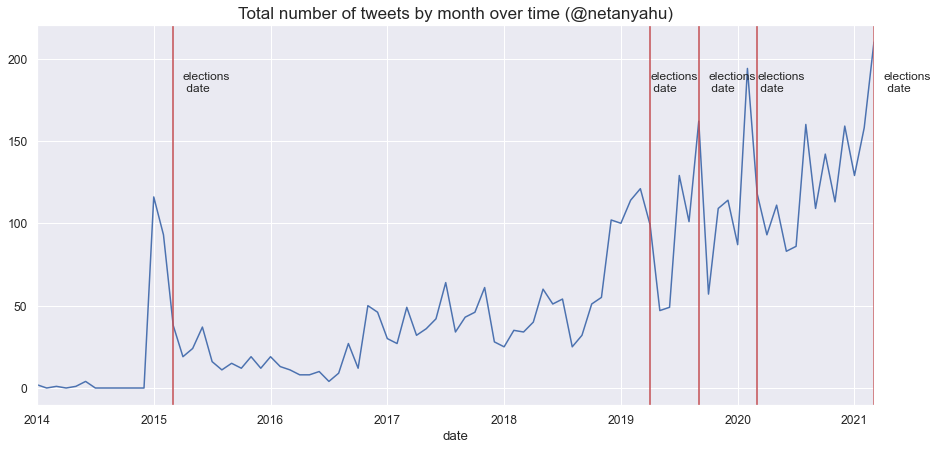

In [23]:
# calculating and plotting tweets by time series vs election dates, and 3 preceding months agg average number of tweets 

df['2014':].resample('M')['tweet'].count().plot(figsize=(15,7),y="");
plt.title("Total number of tweets by month over time (@netanyahu)",size=17);
for d in election_dates:
    plt.axvline(dt.datetime.fromisoformat(d), color='r')
    plt.text(dt.datetime.fromisoformat(d)+dt.timedelta(20),180,f'elections\n date',size=12)
for i in time_range_b4_elections:
    print(f"The average number of tweets per month in the three months preceding the election of {i[1]}: "\
          ,round(df[i[0]:i[1]].tweet.count()/3))
print()
print('When there is no election on the horizon (2015-04 -> 2018-12), the average number of tweets per month is:',
      round(df['2015-04':'2018-12-31'].groupby(pd.Grouper(freq='M'))['tweet'].count().mean()))

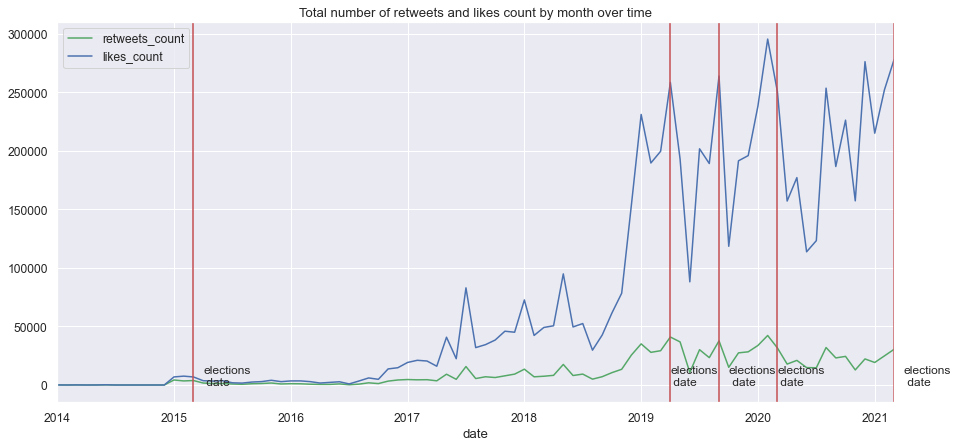

In [24]:
df['2014':].resample('M')[['retweets_count','likes_count']].sum().plot(figsize=(15,7), color=['g','b']);
plt.title("Total number of retweets and likes count by month over time");
for d in election_dates:
    plt.axvline(dt.datetime.fromisoformat(d), color='r')
    plt.text(dt.datetime.fromisoformat(d)+dt.timedelta(20),180,f'elections\n date',size=12)

### Comparing the <u>top dates</u> with the most daily tweets to <u>election dates</u>.

In [25]:
# Top dates with the highest number of tweets
df.date.value_counts().head(10).to_frame('tweets_count')

tweets_count
2019-09-17            26
2015-01-05            26
2021-03-22            25
2021-03-23            23
2015-01-11            21
2019-04-09            19
2019-09-16            17
2020-03-02            17
2008-12-08            17
2021-03-07            15

In [26]:
# Check if the election dates are also in the list of dates with the highest number of tweets.
for i in df.date.value_counts().head(10).index.strftime('%Y-%m-%d').tolist():
    if i in election_dates:
        print(i)

2019-09-17
2021-03-23
2019-04-09
2020-03-02


### ** As can be seen, four out of the five election days are also among the <u>top tweeting dates</u>.

#### * I wrote a function that uses <u>GoogleNews</u> to investigate what happened in the news in order to explain the other dates (not election days) that in the top tweeting days.


In [27]:
def news_headline(date):
    """
    Return 5 news headlines (Israel/Hebrew) for a given date. 
    """
    gn = GoogleNews(country="Israel", lang="he")
    search = gn.search("◊†◊™◊†◊ô◊î◊ï",from_=date, to_=str(dt.datetime.fromisoformat(date) + pd.Timedelta(days=1)))
    newsitem = search['entries']
    for i in newsitem[:5]:
        print(i.title)
        
for i in df.date.value_counts().head(10).index.strftime('%Y-%m-%d').tolist():
    if i not in election_dates:
        print(f'News for {i}: \n-------------------')
        print(news_headline(i))

News for 2015-01-05: 
-------------------
◊†◊™◊†◊ô◊î◊ï ◊û◊©◊ô◊ß ◊ß◊û◊§◊ô◊ô◊ü ◊î◊ú◊ô◊õ◊ï◊ì: ◊û◊¶◊ô◊¢ ◊ó◊ï◊ß ◊û◊©◊ô◊ú◊ï◊™ ◊ó◊ì◊© ◊ï◊™◊ï◊ß◊£ ◊ê◊™ ◊î◊©◊û◊ê◊ú - ◊ï◊ï◊ê◊ú◊î! ◊ë◊ó◊ô◊®◊ï◊™ 2021 - ◊ï◊ï◊ê◊ú◊î!
◊ì◊ô◊ï◊®, ◊ô◊ï◊ß◊® ◊î◊û◊ó◊ô◊î, ◊í◊ô◊ï◊° ◊ú◊õ◊ï◊ú◊ù ◊ï◊©◊ô◊ò◊™ ◊î◊û◊û◊©◊ú: ◊î◊ë◊ò◊ó◊ï◊™ ◊†◊™◊†◊ô◊î◊ï ◊©◊ú◊ê ◊û◊ï◊û◊©◊ï - ynet ◊ô◊ì◊ô◊¢◊ï◊™ ◊ê◊ó◊®◊ï◊†◊ï◊™
◊°◊ß◊®: ◊†◊™◊†◊ô◊î◊ï ◊¢◊ì◊ô◊ô◊ü ◊û◊ï◊ë◊ô◊ú, ◊î◊®◊¶◊ï◊í ◊ï◊ú◊ë◊†◊ô ◊†◊©◊ê◊®◊ô◊ù ◊¶◊û◊ï◊ì◊ô◊ù - ◊ï◊ï◊ê◊ú◊î! ◊ë◊ó◊ô◊®◊ï◊™ 2021 - ◊ï◊ï◊ê◊ú◊î!
◊ó◊ï◊ß ◊î◊û◊©◊ô◊ú◊ï◊™ ◊©◊ú ◊†◊™◊†◊ô◊î◊ï: ◊®◊ê◊© ◊î◊û◊§◊ú◊í◊î ◊î◊í◊ì◊ï◊ú◊î - ◊ê◊ï◊ò◊ï◊û◊ò◊ô◊™ ◊®◊ê◊© ◊û◊û◊©◊ú◊î - ynet ◊ô◊ì◊ô◊¢◊ï◊™ ◊ê◊ó◊®◊ï◊†◊ï◊™
◊ñ◊î ◊®◊ê◊© ◊î◊û◊û◊©◊ú◊î ◊†◊™◊†◊ô◊î◊ï ◊ê◊ï ◊î◊û◊ú◊ö ◊î◊ï◊®◊ì◊ï◊°? - ynet ◊ô◊ì◊ô◊¢◊ï◊™ ◊ê◊ó◊®◊ï◊†◊ï◊™
None
News for 2021-03-22: 
-------------------
23:00 ◊¢◊©◊® ◊î◊°◊õ◊†◊ï◊™ ◊ë◊©◊ú◊ò◊ï◊ü ◊©◊ú ◊†◊™◊†◊ô◊î◊ï ◊¢◊ù ◊î◊ó◊®◊ì◊ô◊ù ◊ï◊î◊õ◊î◊†◊ô◊°◊ò◊ô◊ù - ◊õ◊ú◊õ◊ú◊ô◊°◊ò
◊†◊™◊†◊ô◊î◊ï ◊†◊õ◊©◊ú ◊ë◊õ◊ú ◊î◊ô◊¢◊ì◊ô◊ù ◊©◊î◊¶◊ô◊ë ◊ú◊¢◊¶◊û◊ï, ◊ú◊û◊î ◊î◊¶◊ô◊ë◊ï◊® ◊î◊ô◊©◊®◊ê◊ú◊ô ◊û

### Tweet text preprocessing

In [28]:
my_punctuation = string.punctuation.replace(",", "").replace(".","").replace("?","").replace("!","")
def remove_pe(text, p =string.punctuation):
    "remove punctuation and emojis"
    text_without = "".join([c for c in text if c not in p])
    text_without_pe =  emoji.get_emoji_regexp().sub(r'', text_without)
    return text_without_pe

def removeWeirdChars(text):
    weridPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    return weridPatterns.sub(r'', text)

In [29]:
# clean the text from punctuation, emojis, numbers, urls
df['clean_tweet'] = df['tweet'].apply(lambda x: remove_pe(x)).apply(lambda x: re.sub(r'[A-Za-z]|http\S+|[0-9]+', '',x))\
                     .apply(lambda x: removeWeirdChars(x))

In [30]:
# example of clean tweets 
df[["clean_tweet"]].tail(5)

clean_tweet
date                                                                                                                                                                                                               
2021-03-24                  ◊î◊¢◊®◊ë ◊î◊ë◊ê◊†◊ï ◊ê◊™ ◊î◊ú◊ô◊õ◊ï◊ì ◊ú◊î◊ô◊ï◊™ ◊î◊û◊§◊ú◊í◊î ◊î◊í◊ì◊ï◊ú◊î ◊ë◊ô◊©◊®◊ê◊ú ◊ë◊§◊¢◊® ◊í◊ì◊ï◊ú ◊û◊ê◊ï◊ì ◊ê◊†◊ó◊†◊ï ◊ë◊ß◊ô◊ì◊ï◊û◊™  ◊ï◊î◊û◊§◊ú◊í◊î ◊î◊í◊ì◊ï◊ú◊î ◊û◊ê◊ó◊ï◊®◊ô◊†◊ï ◊ë◊ß◊ô◊ì◊ï◊û◊™  ◊ñ◊î◊ï ◊î◊§◊¢◊® ◊î◊í◊ì◊ï◊ú ◊ë◊ô◊ï◊™◊® ◊ë◊ô◊ü ◊©◊™◊ô ◊û◊§◊ú◊í◊ï◊™ ◊û◊ï◊ë◊ô◊ú◊ï◊™ ◊ë◊ô◊©◊®◊ê◊ú ◊ë◊¢◊©◊®◊ï◊™ ◊î◊©◊†◊ô◊ù ◊î◊ê◊ó◊®◊ï◊†◊ï◊™
2021-03-24                                ◊ê◊§◊©◊® ◊ï◊¶◊®◊ô◊ö ◊ú◊î◊ß◊ô◊ù ◊û◊û◊©◊ú◊î ◊ô◊¶◊ô◊ë◊î ◊ë◊ô◊©◊®◊ê◊ú ◊û◊û◊©◊ú◊î ◊©◊î◊õ◊ú◊õ◊ú◊î ◊©◊ú◊†◊ï ◊û◊ó◊ô◊ô◊ë◊™ ◊ê◊ï◊™◊†◊ï ◊ú◊î◊ß◊ô◊ù ◊ê◊†◊ô ◊û◊ï◊©◊ô◊ò ◊ô◊ì ◊ú◊õ◊ú ◊ó◊ë◊®◊ï◊™ ◊ï◊ó◊ë◊®◊ô ◊î◊õ◊†◊°◊™ ◊©◊û◊ê◊û◊ô◊†◊ô◊ù ◊ë◊¢◊ß◊®◊ï◊†◊ï◊™ ◊î◊ú◊ú◊ï ◊ê◊†◊ô ◊û◊¶◊§◊î ◊û◊õ◊ï◊ú◊ù ◊ú◊†◊î◊ï◊í ◊ë◊ì◊®◊ö ◊ì◊ï◊û◊î ◊õ◊ú◊§◊ô◊†◊ï
2021-03-24  ◊î◊©◊¢◊î ◊û◊ó◊ô◊ô◊ë◊™ ◊ñ◊ê◊™ ◊ï◊î◊û◊ì◊ô◊†◊î ◊ñ◊ß◊ï◊ß◊î ◊ú◊û◊û◊©◊ú◊î ◊ô◊¶◊ô◊ë◊î ◊ê◊°◊ï◊® ◊ú◊†◊ï ◊ë◊©◊ï◊ù ◊ê◊ï◊§◊ü ◊ú◊í◊®◊ï◊® ◊ê◊™ ◊ô◊©◊®◊ê◊ú ◊ú◊ë◊ó◊ô◊®◊ï◊™ ◊ó◊û◊ô◊©◊ô◊ï◊™  ◊¶◊®◊ô◊ö ◊ú◊î◊ß◊ô◊ù ◊û◊û◊©◊ú◊î ◊ô◊¶◊ô◊ë◊î ◊¢◊õ◊©◊ô◊ï ◊õ◊ú ◊ê◊§◊©◊®◊ï◊™ ◊ê◊ó◊®◊™ ◊™◊ë◊ô◊ê ◊ê◊ï◊™◊†◊ï ◊û◊î◊® ◊ê◊ï ◊û◊î◊® ◊ô◊ï◊™◊® ◊ú◊ë◊ó◊ô◊®◊ï◊™ ◊ó◊û◊ô◊©◊ô◊ï◊™ ◊ï◊ê◊°◊ï◊® ◊ú◊†◊ï ◊ú◊ú◊õ◊™ ◊ú◊©◊ù
2021-03-24                                                                                          ◊©◊ï◊ó◊ó◊™◊ô ◊î◊¢◊®◊ë ◊¢◊ù ◊õ◊ú ◊ó◊ë◊®◊ô ◊î◊ô◊û◊ô◊ü ◊ï◊ê◊û◊®◊™◊ô ◊ú◊î◊ù ◊ë◊ï◊ê◊ï ◊†◊¢◊©◊î ◊ê◊™ ◊î◊û◊¢◊©◊î ◊î◊ê◊ó◊®◊ê◊ô ◊ï◊†◊ß◊ô◊ù ◊û◊û◊©◊ú◊î ◊ô◊¶◊ô◊ë◊î ◊û◊û◊©◊ú◊î ◊©◊™◊ì◊ê◊í ◊ú◊õ◊ú ◊ê◊ñ◊®◊ó◊ô ◊ô◊©◊®◊ê◊ú
2021-03-24                    ◊ë◊ô◊û◊ô◊ù ◊î◊ß◊®◊ï◊ë◊ô◊ù ◊ú◊ê ◊ê◊ó◊°◊ï◊ö ◊©◊ï◊ù ◊û◊ê◊û◊• ◊ë◊ì◊ô◊ë◊ï◊® ◊¢◊ù ◊õ◊ú ◊ó◊ë◊®◊ï◊™ ◊ï◊ó◊ë◊®◊ô ◊î◊õ◊†◊°◊™ ◊õ◊ì◊ô ◊ú◊î◊ë◊ô◊ê ◊ú◊ô◊©◊®◊ê◊ú ◊û◊û◊©◊ú◊î ◊ô◊¶◊ô◊ë◊î ◊ñ◊î ◊û◊î ◊©◊ê◊ñ◊®◊ó◊ô ◊ô◊©◊®◊ê◊ú ◊û◊¶◊§◊ô◊ù ◊ê◊ô◊™◊†◊ï ◊ú◊¢◊©◊ï◊™ ◊ú◊û◊†◊ï◊¢ ◊ë◊ó◊ô◊®◊ï◊™ ◊ó◊û◊ô◊©◊ô◊ï◊™ ◊ï◊ú◊î◊ß◊ô◊ù ◊û◊û◊©◊ú◊î ◊ò◊ï◊ë◊î ◊ï◊ô◊¶◊ô◊ë◊î ◊ú◊ô◊©◊®◊ê◊ú

In [31]:
# importing text file with Hebrew stop words
with open('he_stop_words.txt', "r") as f:
    he_s_words = f.readline().split(',')
he_s_words = [i.strip() for i in he_s_words]

In [32]:
def process_text(text):
    """
    Return tokenized(spliting each tweet to words) and removing Hebrew stop words.
    """
    tokens = word_tokenize(text)
    remove_stopwords = [token for token in tokens if token not in he_s_words]
    return remove_stopwords

In [33]:
df['tokenized_text'] = df['clean_tweet'].apply(process_text)
df[['tokenized_text']].head()

tokenized_text
date                                                                        
2008-10-30                                    [◊ë◊¢◊®◊ë, ◊õ◊†◊°◊ô◊ù, ◊ë◊®◊û◊ú◊î, ◊ï◊ë◊í◊ë◊¢◊™◊ô◊ù]
2008-11-02  [◊†◊õ◊†◊°, ◊¢◊õ◊©◊ô◊ï, ◊ú◊û◊°◊ô◊ë◊™, ◊¢◊ô◊™◊ï◊†◊ê◊ô◊ù, ◊û◊ô◊®◊ô, ◊®◊í◊ë, ◊û◊¶◊ò◊®◊§◊™, ◊ó◊ì◊©◊î, ◊ú◊ú◊ô◊õ◊ï◊ì]
2008-11-03                                             [◊ë◊ô◊©◊ô◊ë◊™, ◊°◊ô◊¢◊î, ◊ë◊õ◊†◊°◊™]
2008-11-05                                  [◊î◊¢◊ú◊ô◊†◊ï, ◊¢◊û◊ï◊ì, ◊™◊ï◊û◊õ◊ô◊ù, ◊ë◊§◊ô◊ô◊°◊ë◊ï◊ß]
2008-11-06                                          [◊¢◊ï◊ë◊ì◊ô◊ù, ◊ë◊û◊®◊•, ◊ê◊™◊®, ◊ó◊ì◊©]

In [34]:
print(f"Out of {df.clean_tweet.str.split(' ').str.len().sum()} words in {len(df)} tweets"\
     f", {df.clean_tweet.str.split(' ').str.len().sum() - df.tokenized_text.str.len().sum()} stop words were removed.") 

Out of 118733 words in 5208 tweets, 32927 stop words were removed.


#### Most common phrases (trigrams)  2008 $\Rightarrow$  today

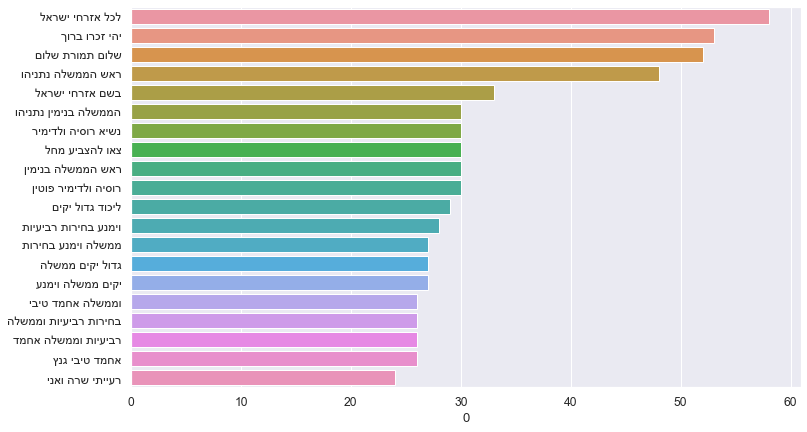

In [35]:
top=20
firstword=""
c=CountVectorizer(stop_words=he_s_words,ngram_range=(3,3))
X=c.fit_transform(df['clean_tweet'].tolist())
words=pd.DataFrame(X.sum(axis=0),columns=c.get_feature_names()).T.sort_values(0,ascending=False).reset_index()
res=words[words['index'].apply(lambda x: firstword in x)].head(top)
terms = [get_display(x) for x in res['index']]; plt.figure(figsize=(12,7))
sns.barplot(x=res[0], y=terms); sns.set(font_scale = 1.5);

#### What words did Benjamin Netanyahu use the most in his tweets <u>within the three months leading up to the five most recent elections</u>? 

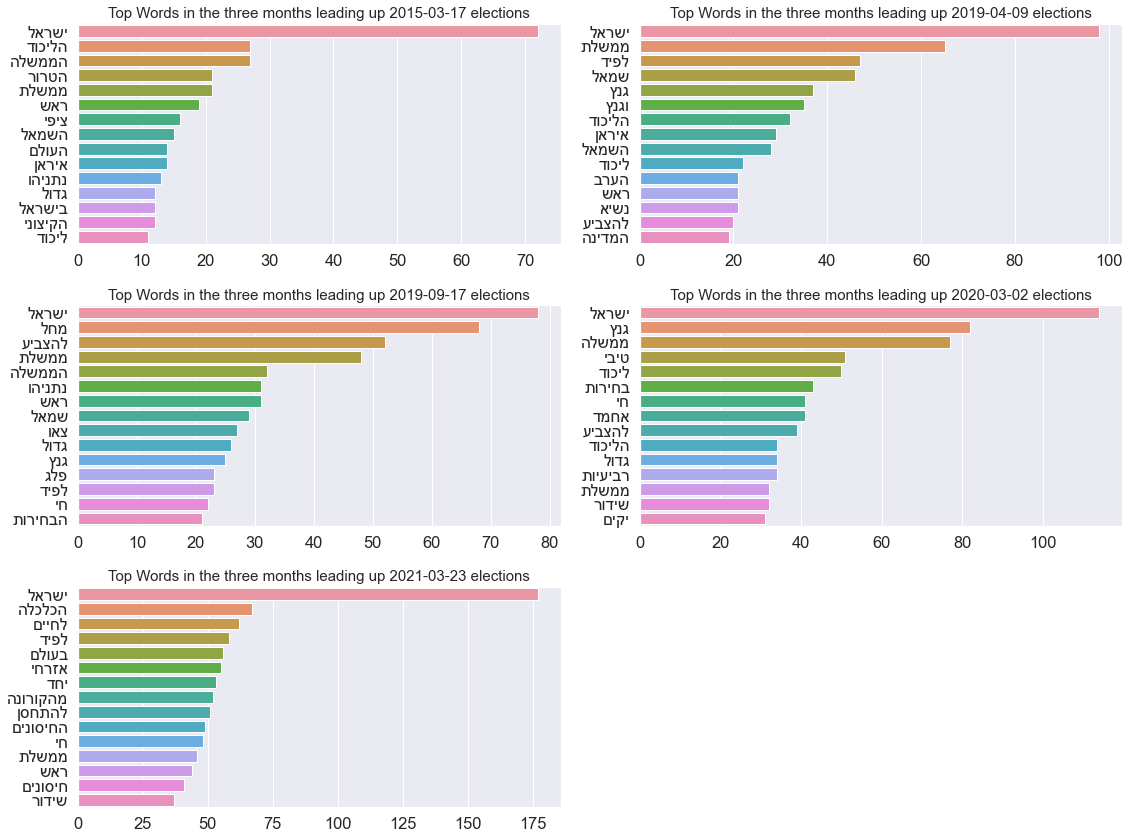

In [36]:
# iterate through each tweet, each token in each tweet, store in a list, plot performance
plt.rcParams['figure.figsize'] = [16, 12]
for index, i in enumerate(time_range_b4_elections):
    flat_words = [item for sublist in df.loc[i[0]:i[1],'tokenized_text'] for item in sublist]
    word_freq = FreqDist(flat_words).most_common(15)
    terms = [get_display(x) for x, y in word_freq]
    count= [y for x, y in word_freq]
    plt.subplot(3, 2, index+1);sns.set(font_scale = 1.5);plt.tight_layout();
    sns.barplot(x=count,y=terms); plt.title(f"Top Words in the three months leading up {i[1]} elections", size=15);

### Words Timeline Occurrences

I wanted to see how words emerge and change in Benjamin Netanyahu's tweets over time, so I created a function that tests when a word appears in tweets, counts the amount of occurrences, and normalizes them to the number of quarterly tweets in order to determine their relative significance.I narrowed the search to 2015 and later, both because it seems that the popularity of usage (as measured by the number of tweets) has grown since then, and because I wanted to review more specific words and events.

In [37]:
def words_over_time(*argv):
    """
    Return timeline bar plot of normalized words count to quarterly sum of tweets
    """
    temp_df = df['2015':][['tweet']].copy()
    for term in argv:
        temp_df[term] = np.where(temp_df.tweet.str.contains(term),1,0)
    temp_df_q = round((temp_df.resample('Q').sum()/temp_df.resample('Q').count()*100),1).fillna(0)
    temp_df_q.index = temp_df_q.index.strftime('%Y-%m')
    temp_df_q = temp_df_q.T[1:]
    temp_df_q.T.plot(kind='bar',width=0.8, figsize=(18,5));
    lgd = [get_display(x) for x in temp_df_q.index]
    plt.legend(lgd,loc='upper left',fontsize=15);ax = plt.axes();
    ax.set_title('Words timeline as a percentage of quarterly tweets', fontsize=15)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())    


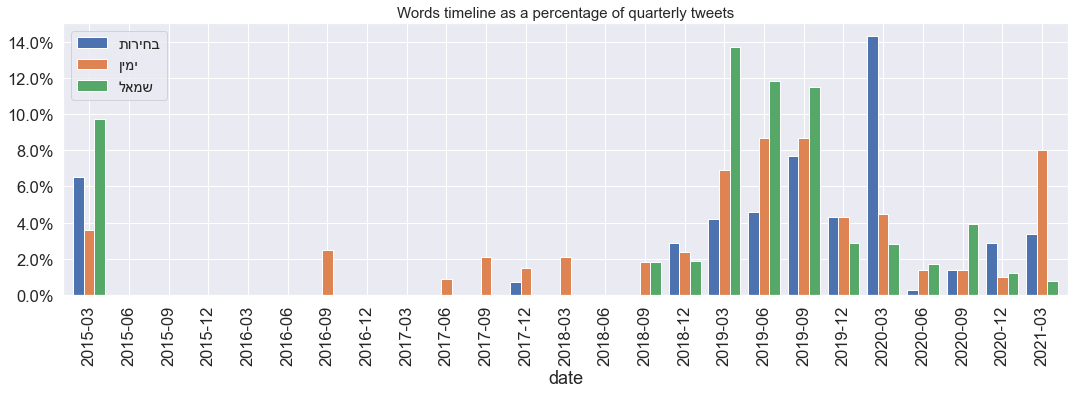

In [38]:
words_over_time('◊ë◊ó◊ô◊®◊ï◊™','◊©◊û◊ê◊ú','◊ô◊û◊ô◊ü')

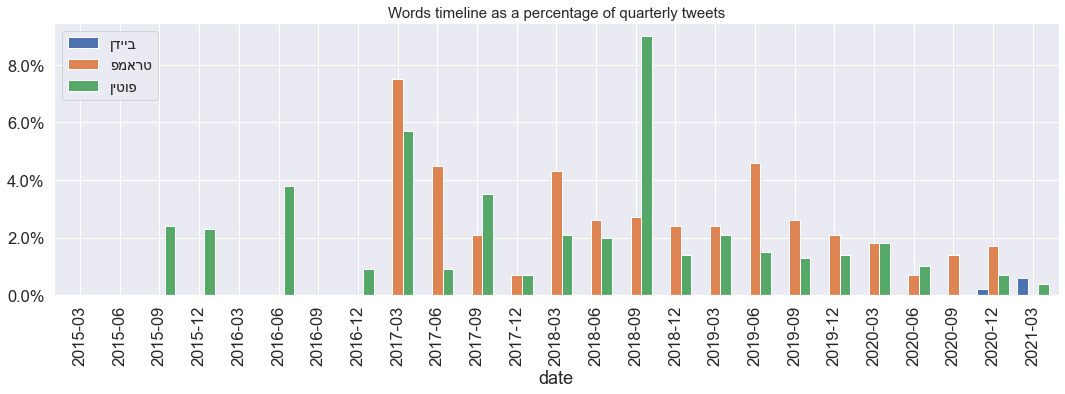

In [39]:
words_over_time('◊ë◊ô◊ô◊ì◊ü','◊ò◊®◊ê◊û◊§','◊§◊ï◊ò◊ô◊ü')

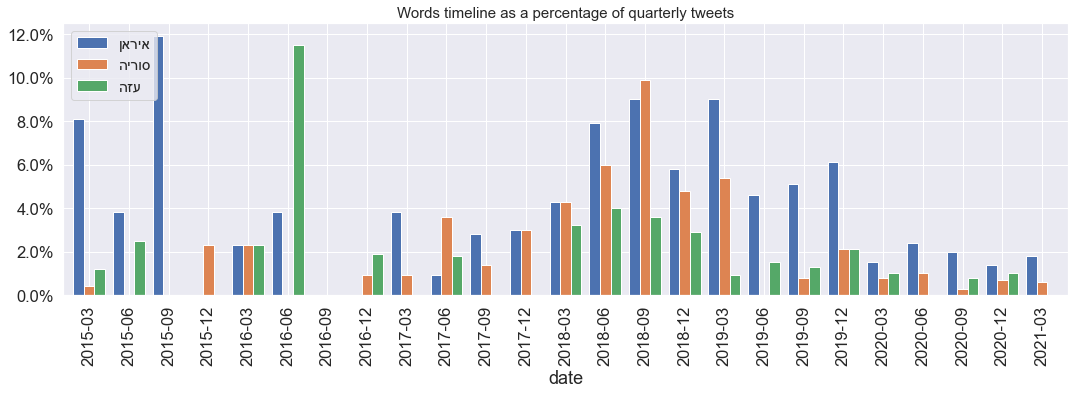

In [40]:
words_over_time('◊ê◊ô◊®◊ê◊ü','◊°◊ï◊®◊ô◊î','◊¢◊ñ◊î')

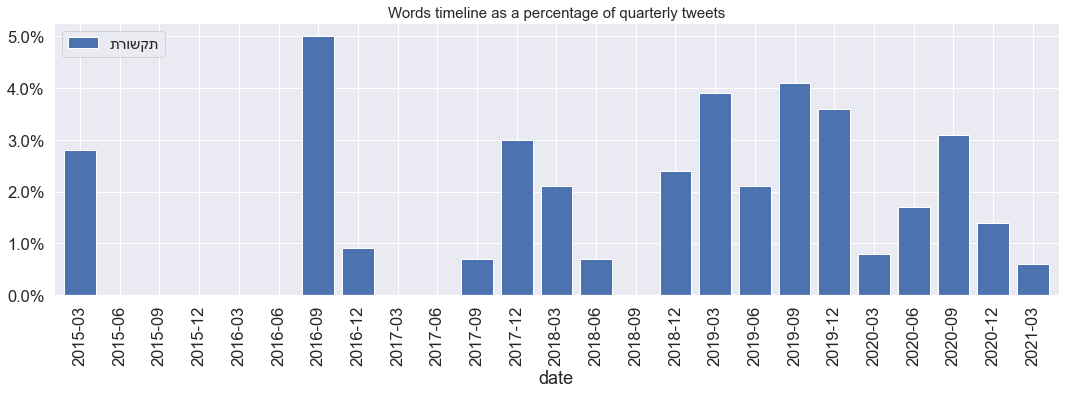

In [41]:
words_over_time('◊™◊ß◊©◊ï◊®◊™')

### <u>Word Cloud</u> 
#### (Text data visualization. Displays a list of words with varying sizes to reflect their significance).

In [42]:
# Making tweets into one big list and putting out the stop words (preparation for word cloud)
temp = " ".join(df['clean_tweet'].tolist())
temp = " ".join([i for i in temp.split() if i not in he_s_words]) 

wordcloud = WordCloud(width=800, height=500,
                      font_path = 'C:\Windows\Fonts\courbd.ttf',
                      background_color='white',max_words=30,
                      min_font_size= 10).generate(get_display(temp))

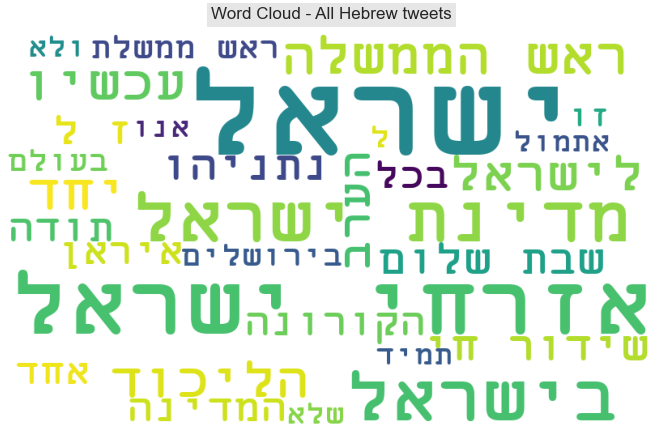

In [43]:
plt.figure(figsize=(9,9))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0);
plt.title("Word Cloud - All Hebrew tweets", backgroundcolor = '0.9', size=17, pad=15);

#### WordCloud by default includes <u>bigrams</u> (sequence of two adjacent words).
#### There seems to be a problem with applying Hebrew-stop words. As we see in the words presentation, the same term appears several times because the stopwords are prefix and suffix connected with the term itself. In this example 'and'/'in'/'the'/'as'/'like'..etc.. 

In [44]:
# An example of the difficulties in replacing stop words in Hebrew. 
tweets_words_example = list(set([word for tokens in df['clean_tweet'].str.split() for word in tokens]))[:10]
tweets_words_example

['◊î◊¶◊ò◊®◊§◊ï◊™◊î',
 '◊î◊©◊ï◊®◊©◊ô◊ù',
 '◊ó◊™◊ü',
 '◊ï◊®◊ë◊ï◊™◊ô◊ô',
 '◊ú◊û◊¢◊ú◊î',
 '◊î◊§◊ô◊ß◊ï',
 '◊û◊ï◊™◊ï',
 '◊ï◊ó◊û◊ô◊ù',
 '◊ò◊ß◊°',
 '◊§◊ï◊†◊ì◊ß◊ê◊ï◊™']

In the example above, half of the words are preceded by prefix letters.  
Stemming and lemmatization can be used to improve language processing (both generate the root form of the inflected words). In Hebrew, stemmer and lemmatizer are complex - you cannot simply trim letters from a word based on its ending, as in English stemmer.  
There is UDPipe, which has a Hebrew lemmatizer, but it has several drawbacks, and I use it in a later segment.  
There is also YAP from the Open University of Israel's ONLP lab, which is relatively complex software that is not yet widely and quickly available.
According to the developers, it will soon be possible to use it more quickly and with compatibility in common libraries.  
For the time being, I would attempt to translate a portion of the dataset in order to use it for other tasks and compare the outcomes.

### Taking the past six months (182 days) tweets and <u>translate</u> them from Hebrew $\Rightarrow$ English

In [45]:
# clean the text from punctuation (except commas & periods), emojis, numbers, urls
df['clean_tweet_for_translate'] = df['tweet'].apply(lambda x: remove_pe(x, my_punctuation))\
                                 .apply(lambda x: re.sub(r'[A-Za-z]|http\S+|[0-9]+', '',x))\
                                 .apply(lambda x: removeWeirdChars(x))

In [46]:
def translate(text):
    """
    Return English translated text.
    """
    translator = Translator()
    result = translator.translate(text,dest='en')
    return result.text

In [47]:
# generating a new data frame from the last six months tweets
# date_6m_ago = (df.tail(1).index.date - dt.timedelta(days=182))[0].strftime('%d/%m/%Y')
# df_with_trans = df[df.index >= date_6m_ago].copy()

In [48]:
# %%time
# # translte Hebrew tweets to English uing GoogleTranslate
# df_with_trans['he_trans'] = df_with_trans['clean_tweet_for_translate'].apply(lambda x: translate(x))

In [49]:
# df_with_trans.to_pickle("./bn_tweets_with_translation.pkl")

In [50]:
df_with_trans = pd.read_pickle("bn_tweets_with_translation.pkl")

#### Examples of Hebrew-to-English tweet translations

In [51]:
df_with_trans[['clean_tweet','he_trans']].rename(columns={'clean_tweet':'Hebrew','he_trans':'English'}).tail(5)

Hebrew  \
date                                                                                                                                                                                                                  
2021-03-24                  ◊î◊¢◊®◊ë ◊î◊ë◊ê◊†◊ï ◊ê◊™ ◊î◊ú◊ô◊õ◊ï◊ì ◊ú◊î◊ô◊ï◊™ ◊î◊û◊§◊ú◊í◊î ◊î◊í◊ì◊ï◊ú◊î ◊ë◊ô◊©◊®◊ê◊ú ◊ë◊§◊¢◊® ◊í◊ì◊ï◊ú ◊û◊ê◊ï◊ì ◊ê◊†◊ó◊†◊ï ◊ë◊ß◊ô◊ì◊ï◊û◊™  ◊ï◊î◊û◊§◊ú◊í◊î ◊î◊í◊ì◊ï◊ú◊î ◊û◊ê◊ó◊ï◊®◊ô◊†◊ï ◊ë◊ß◊ô◊ì◊ï◊û◊™  ◊ñ◊î◊ï ◊î◊§◊¢◊® ◊î◊í◊ì◊ï◊ú ◊ë◊ô◊ï◊™◊® ◊ë◊ô◊ü ◊©◊™◊ô ◊û◊§◊ú◊í◊ï◊™ ◊û◊ï◊ë◊ô◊ú◊ï◊™ ◊ë◊ô◊©◊®◊ê◊ú ◊ë◊¢◊©◊®◊ï◊™ ◊î◊©◊†◊ô◊ù ◊î◊ê◊ó◊®◊ï◊†◊ï◊™   
2021-03-24                                ◊ê◊§◊©◊® ◊ï◊¶◊®◊ô◊ö ◊ú◊î◊ß◊ô◊ù ◊û◊û◊©◊ú◊î ◊ô◊¶◊ô◊ë◊î ◊ë◊ô◊©◊®◊ê◊ú ◊û◊û◊©◊ú◊î ◊©◊î◊õ◊ú◊õ◊ú◊î ◊©◊ú◊†◊ï ◊û◊ó◊ô◊ô◊ë◊™ ◊ê◊ï◊™◊†◊ï ◊ú◊î◊ß◊ô◊ù ◊ê◊†◊ô ◊û◊ï◊©◊ô◊ò ◊ô◊ì ◊ú◊õ◊ú ◊ó◊ë◊®◊ï◊™ ◊ï◊ó◊ë◊®◊ô ◊î◊õ◊†◊°◊™ ◊©◊û◊ê◊û◊ô◊†◊ô◊ù ◊ë◊¢◊ß◊®◊ï◊†◊ï◊™ ◊î◊ú◊ú◊ï ◊ê◊†◊ô ◊û◊¶◊§◊î ◊û◊õ◊ï◊ú◊ù ◊ú◊†◊î◊ï◊í ◊ë◊ì◊®◊ö ◊ì◊ï◊û◊î ◊õ◊ú◊§◊ô◊†◊ï   
2021-03-24  ◊î◊©◊¢◊î ◊û◊ó◊ô◊ô◊ë◊™ ◊ñ◊ê◊™ ◊ï◊î◊û◊ì◊ô◊†◊î ◊ñ◊ß◊ï◊ß◊î ◊ú◊û◊û◊©◊ú◊î ◊ô◊¶◊ô◊ë◊î ◊ê◊°◊ï◊® ◊ú◊†◊ï ◊ë◊©◊ï◊ù ◊ê◊ï◊§◊ü ◊ú◊í◊®◊ï◊® ◊ê◊™ ◊ô◊©◊®◊ê◊ú ◊ú◊ë◊ó◊ô◊®◊ï◊™ ◊ó◊û◊ô◊©◊ô◊ï◊™  ◊¶◊®◊ô◊ö ◊ú◊î◊ß◊ô◊ù ◊û◊û◊©◊ú◊î ◊ô◊¶◊ô◊ë◊î ◊¢◊õ◊©◊ô◊ï ◊õ◊ú ◊ê◊§◊©◊®◊ï◊™ ◊ê◊ó◊®◊™ ◊™◊ë◊ô◊ê ◊ê◊ï◊™◊†◊ï ◊û◊î◊® ◊ê◊ï ◊û◊î◊® ◊ô◊ï◊™◊® ◊ú◊ë◊ó◊ô◊®◊ï◊™ ◊ó◊û◊ô◊©◊ô◊ï◊™ ◊ï◊ê◊°◊ï◊® ◊ú◊†◊ï ◊ú◊ú◊õ◊™ ◊ú◊©◊ù   
2021-03-24                                                                                          ◊©◊ï◊ó◊ó◊™◊ô ◊î◊¢◊®◊ë ◊¢◊ù ◊õ◊ú ◊ó◊ë◊®◊ô ◊î◊ô◊û◊ô◊ü ◊ï◊ê◊û◊®◊™◊ô ◊ú◊î◊ù ◊ë◊ï◊ê◊ï ◊†◊¢◊©◊î ◊ê◊™ ◊î◊û◊¢◊©◊î ◊î◊ê◊ó◊®◊ê◊ô ◊ï◊†◊ß◊ô◊ù ◊û◊û◊©◊ú◊î ◊ô◊¶◊ô◊ë◊î ◊û◊û◊©◊ú◊î ◊©◊™◊ì◊ê◊í ◊ú◊õ◊ú ◊ê◊ñ◊®◊ó◊ô ◊ô◊©◊®◊ê◊ú   
2021-03-24                    ◊ë◊ô◊û◊ô◊ù ◊î◊ß◊®◊ï◊ë◊ô◊ù ◊ú◊ê ◊ê◊ó◊°◊ï◊ö ◊©◊ï◊ù ◊û◊ê◊û◊• ◊ë◊ì◊ô◊ë◊ï◊® ◊¢◊ù ◊õ◊ú ◊ó◊ë◊®◊ï◊™ ◊ï◊ó◊ë◊®◊ô ◊î◊õ◊†◊°◊™ ◊õ◊ì◊ô ◊ú◊î◊ë◊ô◊ê ◊ú◊ô◊©◊®◊ê◊ú ◊û◊û◊©◊ú◊î ◊ô◊¶◊ô◊ë◊î ◊ñ◊î ◊û◊î ◊©◊ê◊ñ◊®◊ó◊ô ◊ô◊©◊®◊ê◊ú ◊û◊¶◊§◊ô◊ù ◊ê◊ô◊™◊†◊ï ◊ú◊¢◊©◊ï◊™ ◊ú◊û◊†◊ï◊¢ ◊ë◊ó◊ô◊®◊ï◊™ ◊ó◊û◊ô◊©◊ô◊ï◊™ ◊ï◊ú◊î◊ß◊ô◊ù ◊û◊û◊©◊ú◊î ◊ò◊ï◊ë◊î ◊ï◊ô◊¶◊ô◊ë◊î ◊ú◊ô◊©◊®◊ê◊ú   

                                                                                                                                                                                                                                                                                       English  
date                                                                                                                                                                                                                                                                                            
2021-03-24                                         The evening we brought the Likud to be the largest party in Israel in a very large gap.We are in the prefix and the largest party behind us in the prefix.This is the largest gap between two leading parties in Israel in the last decades  
2021-03-24                                  It is possible to establish a stable government in Israel.The government whose economy requires us to establish.I reach for all membership and members of the Knesset who believe in these principles.I expect anyone to drive a similar way to us  
2021-03-24                 The time requires it and the state needs a stable government.We are not allowed in any way to drag Israel to fifth elections should establish a stable government now.Any other option will bring us quickly or faster for fifth elections and we must not go there  
2021-03-24                                                                                                                     I talked tonight with all the right members and told them let's do the act in charge of a stable government, a government to worry about all citizens of Israel  
2021-03-24  In the coming days, I will not take any effort to speak with any companies and members of the Knesset in order to bring Israel a stable government.That's what Israel's citizens look forward to doing.Avoid fifth elections and establish a good government an

In [52]:
# Making tweets into one big list and putting out the stop words
temp1 = " ".join(df_with_trans['he_trans'].tolist())
temp1 = " ".join([i for i in temp1.split() if i not in stopwords.words('english')]) 

In [53]:
wordcloud = WordCloud(width=800, height=500,
                      background_color='white',max_words=30,
                      min_font_size= 10).generate(temp1)

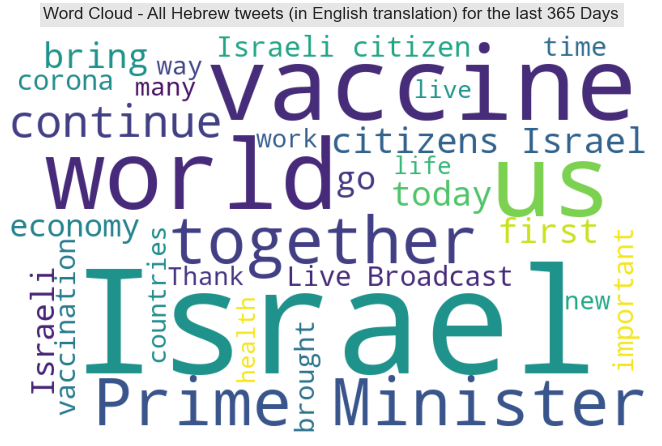

In [54]:
plt.figure(figsize=(9,9))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0);
plt.title("Word Cloud - All Hebrew tweets (in English translation) for the last 365 Days",\
          backgroundcolor = '0.9',size=17, pad=15);

### <u>Named-entity recognition (NER)</u>
#### Lets see how Spacy handle information extraction that seeks to locate and classify named entities mentioned in our tweets text into pre-defined categories such as person names, organizations, locations, time expressions etc.

In [55]:
nlp = en_core_web_sm.load()
ent = nlp(temp1)
df_ent = pd.DataFrame([(X.text, X.label_) for X in ent.ents], columns = ['Word','Entity'])

#### Organizations

In [56]:
df_ent.where(df_ent['Entity'] == 'ORG').value_counts().head()

Word          Entity
Likud         ORG       60
State Israel  ORG       21
GPO           ORG       20
Knesset       ORG       10
State         ORG        8
dtype: int64

#### Persons

In [57]:
df_ent.where(df_ent['Entity'] == 'PERSON').value_counts().head()

Word        Entity
Netanyahu   PERSON    27
Sarah       PERSON    15
Corona      PERSON    10
Yair Lapid  PERSON     8
Trump       PERSON     7
dtype: int64

#### Geo-Political Entity

In [58]:
df_ent.where(df_ent['Entity'] == 'GPE').value_counts().head()

Word       Entity
Israel     GPE       328
Jerusalem  GPE        24
Iran       GPE        17
Bahrain    GPE        14
Korona     GPE        11
dtype: int64

#### Nationalities or religious or political groups

In [59]:
df_ent.where(df_ent['Entity'] == 'NORP').value_counts().head()

Word      Entity
Israeli   NORP      105
Arab      NORP       34
Jewish    NORP       17
Israelis  NORP       14
European  NORP       10
dtype: int64

#### Date

In [60]:
df_ent.where(df_ent['Entity'] == 'DATE').value_counts().head()

Word       Entity
today      DATE      46
Today      DATE      11
yesterday  DATE      10
years      DATE       8
months     DATE       7
dtype: int64

#### Cardinal (numbers that do not fit into another category)

In [61]:
df_ent.where(df_ent['Entity'] == 'CARDINAL').value_counts().head()

Word       Entity  
millions   CARDINAL    22
two        CARDINAL    19
one        CARDINAL    19
million    CARDINAL     8
A million  CARDINAL     4
dtype: int64

#### Time

In [62]:
df_ent.where(df_ent['Entity'] == 'TIME').value_counts().head()

Word     Entity
evening  TIME      4
morning  TIME      4
tonight  TIME      3
hours    TIME      3
night    TIME      3
dtype: int64

#### Events

In [63]:
df_ent.where(df_ent['Entity'] == 'EVENT').value_counts().head()

Word                      Entity
Holocaust                 EVENT     1
International Day         EVENT     1
Operation "Returns Life"  EVENT     1
The Yom Kippur War        EVENT     1
World Champions!We'll     EVENT     1
dtype: int64

<b>NER generating raw markup example:</b>

In [64]:
displacy.render(nlp(df_with_trans['he_trans'].tail(1).values[0]), jupyter=True, style='ent')

### NER conclusion: Not perfect, to say the least. There are a number of recognition mistakes, most of them within the Organization entities.

## <u>Sentiment Analysis</u>  
with TextBlob

In [65]:
df_with_trans['polarity'] = df_with_trans['he_trans'].apply(lambda x:TextBlob(x).sentiment[0])
df_with_trans['subjectivity'] = df_with_trans['he_trans'].apply(lambda x:TextBlob(x).sentiment[1])
df_with_trans['sentiment'] = df_with_trans['polarity'].apply(lambda x: 'pos' if x>0 else ('neg' if x<0 else 'neu'))

In [66]:
sp_corr= df_with_trans[['polarity','subjectivity']].corr().iloc[1,0].round(2)
print(f'There is a positive correlation of {sp_corr} between subjectivity and polarity in the tweets.')

There is a positive correlation of 0.57 between subjectivity and polarity in the tweets.


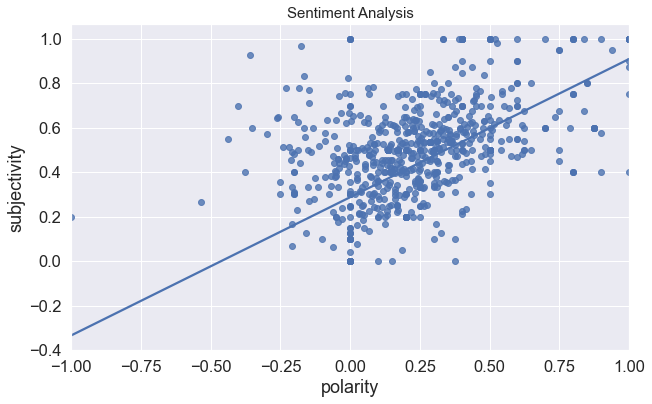

In [67]:
plt.figure(figsize=(10,6))
sns.regplot(x='polarity',y='subjectivity', data=df_with_trans,ci=None)\
.set_title('Sentiment Analysis',size=15);

Positive & Negative (%)
pos    66.17
neu    23.95
neg     9.88
Name: sentiment, dtype: float64


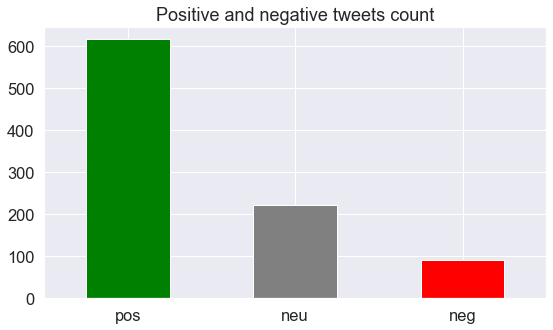

In [68]:
df_with_trans['sentiment'].value_counts().plot(kind='bar', color=['green','grey','red'],
                           figsize=(9,5),title="Positive and negative tweets count"); plt.xticks(rotation=0);

print('Positive & Negative (%)')
print(round(df_with_trans['sentiment'].value_counts(normalize=True)*100,2))

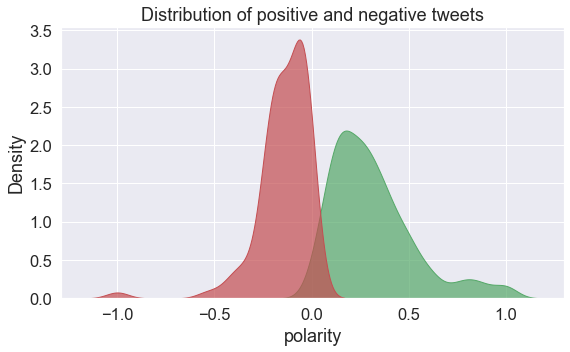

In [69]:
plt.figure(figsize=(9,5))
sns.kdeplot(df_with_trans[df_with_trans['polarity']>0]['polarity'], color="g", shade=True, alpha=0.7)
sns.kdeplot(df_with_trans[df_with_trans['polarity']<0]['polarity'], color="r", shade=True, alpha=0.7);
plt.title("Distribution of positive and negative tweets");

In [70]:
df_with_trans.loc[df_with_trans['polarity']>0].nlargest(3,'polarity')[['clean_tweet','polarity']]

clean_tweet  polarity
date                                                   
2020-10-09  ◊©◊ë◊™ ◊©◊ú◊ï◊ù ◊ï◊ó◊í ◊©◊û◊ó ◊ú◊õ◊ú ◊ê◊ñ◊®◊ó◊ô ◊ô◊©◊®◊ê◊ú        1.0
2020-11-16                    ◊ó◊í ◊°◊ô◊í◊ì ◊©◊û◊ó           1.0
2020-12-11    ◊©◊ë◊™ ◊©◊ú◊ï◊ù ◊ï◊ó◊í ◊ó◊†◊ï◊õ◊î ◊©◊û◊ó ◊ú◊õ◊ï◊ú◊õ◊ù         1.0

In [71]:
df_with_trans.loc[df_with_trans['polarity']<0].nsmallest(1,'polarity')[['clean_tweet_for_translate', 'he_trans','polarity']]

clean_tweet_for_translate  \
date                                                                                                                
2021-03-11  ◊™◊ï◊ì◊î ◊ú◊õ◊ù ◊¢◊ú ◊ê◊ô◊ó◊ï◊ú◊ô ◊î◊î◊ó◊ú◊û◊î ◊ï◊î◊ë◊®◊ô◊ê◊ï◊™ ◊ú◊®◊¢◊ô◊ô◊™◊ô ◊©◊®◊î. ◊®◊ô◊í◊©◊™◊ù ◊ê◊ï◊™◊†◊ï. ◊©◊®◊î ◊ï◊ê◊†◊ô ◊û◊ï◊ì◊ô◊ù ◊ú◊õ◊ï◊ú◊õ◊ù. ◊ê◊ï◊î◊ë◊ô◊ù ◊ê◊™◊õ◊ù!   .   

                                                                                                                        he_trans  \
date                                                                                                                               
2021-03-11  Thank you for the grief of recovery and health to my wife Sarah.You moved us.Sarah and I thank all of you.love you!.   

            polarity  
date                  
2021-03-11      -1.0

#### As we can see, there are certain complexities in the definition of sentiment in terms of sarcasm/cynicism such as the use of opposing negative/positive expressions, and poor translation as within the example above..

#### >   <font color='red'>*The results of sentiment ratings must be treated with caution. Sentiment in TextBlob is based on signaling sentiment for each particular word. When translating from Hebrew to English, we run into a challenge, as I said, with sarcasm (which is also similar to the use of sarcasm in other languages) and inaccurate translation of some terms, since there are words in Hebrew that have several meanings.***</font>

## <u>Sentiment Analysis with HeBERT</u>   
Pre-trained BERT for Polarity Analysis

As we have shown, sentiment analysis suffers from a variety of defects. As a result, I wanted to take a different approach, using tweets in <b>Hebrew</b> (rather than translated ones) and a neural network model that had already been trained on Hebrew corpora.  
We well use it as a sentiment classification model (polarity ONLY).

HeBERT is a Hebrew pretrained language model. It is based on Google's BERT architecture and it is BERT-Base config **[Link](https://github.com/avichaychriqui/HeBERT)

In [72]:
from transformers import AutoTokenizer, AutoModel, pipeline
tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT_sentiment_analysis")
model = AutoModel.from_pretrained("avichr/heBERT_sentiment_analysis")

In [73]:
sentiment_analysis = pipeline(
    "sentiment-analysis",
    model="avichr/heBERT_sentiment_analysis",
    tokenizer="avichr/heBERT_sentiment_analysis",
    return_all_scores = True)


In [74]:
df_heBert = df_with_trans.copy()
df_heBert['s_heBert'] = df_heBert['clean_tweet_for_translate'].apply(lambda x: sentiment_analysis(x))

In [75]:
df_heBert['natural'] = df_heBert['s_heBert'].apply(lambda x: float([d['score'] for d in x[0] if d['label'] == 'natural'][0]))
df_heBert['positive'] = df_heBert['s_heBert'].apply(lambda x: float([d['score'] for d in x[0] if d['label'] == 'positive'][0]))
df_heBert['negative'] = df_heBert['s_heBert'].apply(lambda x: float([d['score'] for d in x[0] if d['label'] == 'negative'][0]))

In [76]:
df_heBert['s_heBert_label'] = np.where(df_heBert['positive']>0.5, 'pos',
                              np.where(df_heBert['negative']>0.5, 'neg', 'neu'))

Positive & Negative (%)
pos    49.84
neg    42.21
neu     7.95
Name: s_heBert_label, dtype: float64


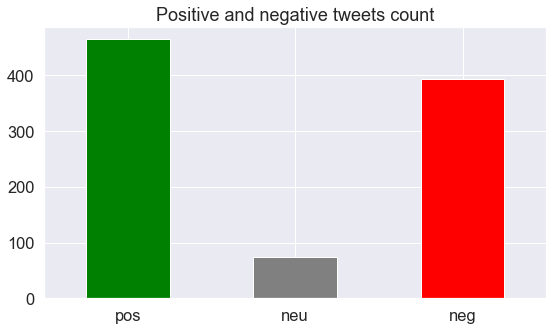

In [77]:
df_heBert['s_heBert_label'].value_counts()[['pos','neu','neg']].plot(kind='bar', color=['green','grey','red'],
                            figsize=(9,5),title="Positive and negative tweets count"); plt.xticks(rotation=0);

print('Positive & Negative (%)')
print(round(df_heBert['s_heBert_label'].value_counts(normalize=True)*100,2))

In [78]:
# examples of positive tweets
df_heBert.loc[df_heBert['positive']>0.5].nlargest(3,'positive')[['clean_tweet','positive']]

clean_tweet  \
date                                                                                                                                                                                                                                                                      
2021-01-06                                           ◊î◊™◊®◊í◊©◊™◊ô ◊ú◊§◊í◊ï◊© ◊î◊ô◊ï◊ù ◊ê◊™ ◊î◊ô◊ú◊î ◊©◊ï◊®◊• ◊ë◊û◊™◊ó◊ù ◊î◊ó◊ô◊°◊ï◊†◊ô◊ù ◊ë◊ô◊®◊ï◊©◊ú◊ô◊ù  ◊î◊ô◊ú◊î ◊ë◊™  ◊û◊™◊ï◊ß◊î ◊ê◊û◊ô◊™◊ô◊™ ◊©◊û◊ê◊ï◊ë◊ó◊†◊™ ◊¢◊ù ◊™◊°◊û◊ï◊†◊™ ◊†◊ì◊ô◊®◊î ◊ú◊û◊®◊ï◊™ ◊õ◊ú ◊î◊ß◊©◊ô◊ô◊ù ◊î◊ô◊ê ◊†◊ú◊ó◊û◊™ ◊¢◊ú ◊î◊ó◊ô◊ô◊ù ◊û◊™◊ï◊ö ◊©◊û◊ó◊î ◊ï◊ê◊î◊ë◊î ◊ê◊ì◊ô◊®◊î ◊î◊ô◊ô◊™◊î ◊ú◊ô ◊î◊ñ◊õ◊ï◊™ ◊ú◊î◊õ◊ô◊® ◊ê◊ï◊™◊î ◊î◊ô◊ï◊ù ◊î◊®◊ë◊î ◊ë◊®◊ô◊ê◊ï◊™ ◊î◊ô◊ú◊î     
2021-03-12  ◊™◊ï◊ì◊î ◊®◊ë◊î ◊ê◊ú◊ë◊®◊ò ◊ë◊ï◊®◊ú◊î ◊û◊†◊õ◊¥◊ú ◊§◊ô◊ô◊ñ◊® ◊¢◊ú ◊î◊ê◊û◊ï◊ü ◊©◊†◊™◊™ ◊ë◊ô ◊ï◊ë◊ê◊ñ◊®◊ó◊ô ◊ô◊©◊®◊ê◊ú ◊™◊ï◊ì◊î ◊ú◊õ◊ù ◊ê◊ñ◊®◊ó◊ô ◊ô◊©◊®◊ê◊ú ◊¢◊ú ◊î◊î◊ß◊®◊ë◊î ◊ë◊©◊†◊î ◊î◊ê◊ó◊®◊ï◊†◊î ◊ô◊ó◊ì ◊î◊§◊õ◊†◊ï ◊ê◊™ ◊ô◊©◊®◊ê◊ú ◊ú◊î◊¶◊ú◊ó◊î ◊¢◊ï◊ú◊û◊ô◊™ ◊ï◊™◊ß◊ï◊ï◊î ◊ú◊ê◊†◊ï◊©◊ï◊™ ◊õ◊ï◊ú◊î ◊õ◊§◊ô ◊©◊î◊ô◊ô◊™◊ô ◊ê◊ï◊ë◊°◊°◊ô◊ë◊ô ◊ú◊ó◊ô◊°◊ï◊†◊ô◊ù ◊¢◊õ◊©◊ô◊ï ◊ê◊†◊ô ◊ê◊ï◊ë◊°◊°◊ô◊ë◊ô ◊ú◊î◊ñ◊†◊ô◊ß ◊ê◊™ ◊î◊õ◊ú◊õ◊ú◊î ◊©◊ú◊†◊ï ◊ú◊û◊ß◊ï◊ù ◊î◊®◊ê◊©◊ï◊ü ◊ë◊¢◊ï◊ú◊ù     
2021-02-25                                                                                                                                        ◊î◊ô◊ú◊ì◊ô◊ù ◊î◊û◊™◊ï◊ß◊ô◊ù ◊©◊§◊í◊©◊™◊ô ◊ê◊™◊û◊ï◊ú ◊¢◊ù ◊¢◊û◊ï◊™◊™ ◊¥◊®◊ó◊©◊ô ◊ú◊ë◊¥ ◊ú◊ô◊û◊ì◊ï ◊ê◊ï◊™◊ô ◊¢◊ú ◊¢◊ï◊¶◊û◊î ◊ï◊í◊ë◊ï◊®◊î ◊ê◊ï◊î◊ë ◊ê◊™◊õ◊ù ◊û◊ê◊ï◊ì ◊®◊§◊ï◊ê◊î ◊©◊ú◊û◊î ◊û◊õ◊ú ◊ê◊ñ◊®◊ó◊ô ◊ô◊©◊®◊ê◊ú     

            positive  
date                  
2021-01-06  0.999762  
2021-03-12  0.999762  
2021-02-25  0.999762

In [79]:
# examples of negative tweets
df_heBert.loc[df_heBert['negative']>0.5].nlargest(3,'negative')[['clean_tweet','negative']]

clean_tweet  \
date                                                                                                                                                                                                                                                                                 
2021-02-10                                                                                                    ◊ë◊ü ◊í◊ë◊ô◊® ◊ú◊ê ◊ô◊î◊ô◊î ◊ë◊û◊û◊©◊ú◊î ◊ê◊ë◊ú ◊õ◊û◊î ◊¶◊ë◊ô◊¢◊ï◊™ ◊ñ◊î ◊ú◊î◊™◊¢◊ú◊ù ◊û◊ó◊ë◊®◊™ ◊û◊§◊ú◊í◊™ ◊î◊¢◊ë◊ï◊ì◊î ◊©◊û◊ë◊ñ◊î ◊ê◊™ ◊î◊¶◊§◊ô◊®◊î ◊ë◊ô◊ï◊ù ◊î◊©◊ï◊ê◊î ◊ï◊©◊ë◊ú◊¢◊ì◊ô◊î ◊ú◊í◊ì◊¢◊ï◊ü ◊ë◊†◊ò ◊ï◊ú◊§◊ô◊ì ◊ê◊ô◊ü ◊û◊û◊©◊ú◊î ◊®◊ß ◊ê◊†◊ó◊†◊ï ◊†◊ß◊ô◊ù ◊û◊û◊©◊ú◊™ ◊ô◊û◊ô◊ü ◊¢◊ú ◊û◊ú◊ê      
2021-03-01                ◊û◊ê◊ú◊î ◊©◊†◊§◊ò◊®◊ï ◊û◊î◊ß◊ï◊®◊ï◊†◊î ◊ú◊ê ◊î◊ô◊ï ◊û◊ó◊ï◊°◊†◊ô◊ù ◊ë◊©◊™◊ô ◊û◊†◊ï◊™ ◊ú◊õ◊ü ◊ê◊†◊ô ◊ú◊ê ◊û◊ï◊õ◊ü ◊ú◊°◊ë◊ï◊ú ◊ê◊™ ◊©◊ô◊ë◊ï◊© ◊î◊†◊ó◊ô◊ï◊™ ◊î◊ë◊®◊ô◊ê◊ï◊™ ◊ï◊ê◊™ ◊î◊ì◊î◊ú◊í◊ô◊ò◊ô◊û◊¶◊ô◊î ◊ú◊ó◊ô◊°◊ï◊†◊ô◊ù ◊©◊¢◊ï◊©◊ô◊ù ◊§◊ï◊ú◊ô◊ò◊ô◊ß◊ê◊ô◊ù ◊¶◊ô◊†◊ô◊ô◊ù ◊ê◊ú◊ô◊î◊ù ◊î◊™◊ô◊ô◊ó◊°◊™◊ô ◊î◊ô◊ï◊ù ◊ô◊© ◊ú◊ô ◊ê◊§◊° ◊°◊ë◊ú◊†◊ï◊™ ◊ú◊§◊ô◊ô◊ß ◊†◊ô◊ï◊ñ ◊ë◊ñ◊û◊ü ◊©◊ê◊†◊ô ◊†◊ú◊ó◊ù ◊ú◊î◊¶◊ú◊™ ◊ó◊ô◊ô◊ù ◊ú◊õ◊ï ◊ú◊î◊™◊ó◊°◊ü ◊ï◊î◊¶◊ô◊ú◊ï ◊ê◊™ ◊î◊ó◊ô◊ô◊ù ◊©◊ú◊õ◊ù   
2020-12-21  ◊ñ◊î ◊û◊¶◊¢◊® ◊ê◊ï◊™◊ô ◊õ◊ô ◊ë◊û◊ß◊ï◊ù ◊ú◊ê◊§◊©◊® ◊ú◊û◊û◊©◊ú◊î ◊ú◊¢◊ë◊ï◊ì ◊ú◊û◊¢◊ü ◊î◊ê◊ñ◊®◊ó◊ô◊ù ◊î◊î◊™◊¢◊ß◊©◊ï◊™ ◊î◊ô◊ê ◊ú◊î◊û◊©◊ô◊ö ◊¥◊û◊û◊©◊ú◊î ◊ë◊™◊ï◊ö ◊û◊û◊©◊ú◊î◊¥ ◊ë◊†◊ô◊°◊ô◊ï◊ü ◊õ◊ï◊©◊ú ◊ú◊ß◊ï◊©◊© ◊ß◊ï◊ú◊ï◊™ ◊ú◊û◊§◊ú◊í◊î ◊©◊ú◊ê ◊ë◊ì◊ô◊ï◊ß ◊û◊¶◊ú◊ô◊ó◊î ◊ë◊°◊ß◊®◊ô◊ù  ◊ê◊†◊ó◊†◊ï ◊ú◊ê ◊®◊ï◊¶◊ô◊ù ◊ë◊ó◊ô◊®◊ï◊™ ◊ï◊ú◊õ◊ü ◊î◊ô◊ô◊†◊ï ◊û◊ï◊õ◊†◊ô◊ù ◊ú◊î◊¶◊ë◊ô◊¢ ◊ë◊õ◊†◊°◊™ ◊†◊í◊ì ◊ë◊ó◊ô◊®◊ï◊™ ◊ï◊ú◊î◊û◊©◊ô◊ö ◊ô◊ó◊ì ◊ê◊ë◊ú ◊ê◊ù ◊ë◊ó◊ô◊®◊ï◊™ ◊ô◊õ◊§◊ï ◊¢◊ú◊ô◊†◊ï ◊ê◊†◊ó◊†◊ï ◊†◊†◊¶◊ó    

            negative  
date                  
2021-02-10  0.999901  
2021-03-01  0.999901  
2020-12-21  0.999900

In [80]:
textBlob_sentiment = df_with_trans['sentiment'].value_counts(normalize=True)[['pos','neu','neg']]
heBert_sentiment = df_heBert['s_heBert_label'].value_counts(normalize=True)[['pos','neu','neg']]
textBlob_v_heBert = pd.concat([textBlob_sentiment, heBert_sentiment], keys= ['textBlob', 'heBert'], axis=1).T

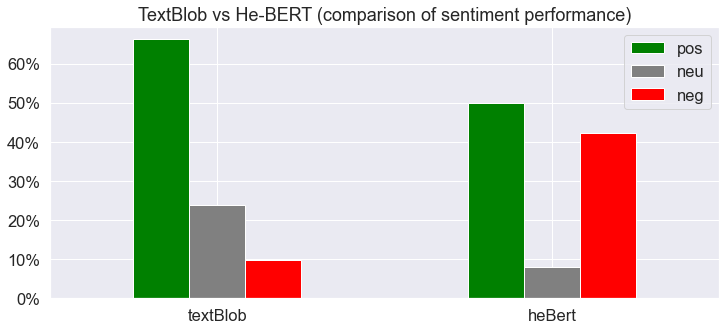

In [81]:
ax = textBlob_v_heBert.plot(kind='bar',color=['green','grey','red'],figsize=(12,5),
                       title="TextBlob vs He-BERT (comparison of sentiment performance)"); plt.xticks(rotation=0);
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

**There is a considerable difference between the two models. Provided that Bert's model was trained on a Hebrew corpus, as well as his input in Hebrew rather than English translated from Hebrew (with all of the of the related issues I described earlier), and after inspecting some of the translations, it appears that the He-BERT model is more accurate and consistent.**

In [82]:
last_6m_sentiment = df_heBert.groupby('s_heBert_label').resample('W').size().unstack(0, fill_value=0)
last_6m_sentiment.index = last_6m_sentiment.index.strftime('%y-%m-%d')

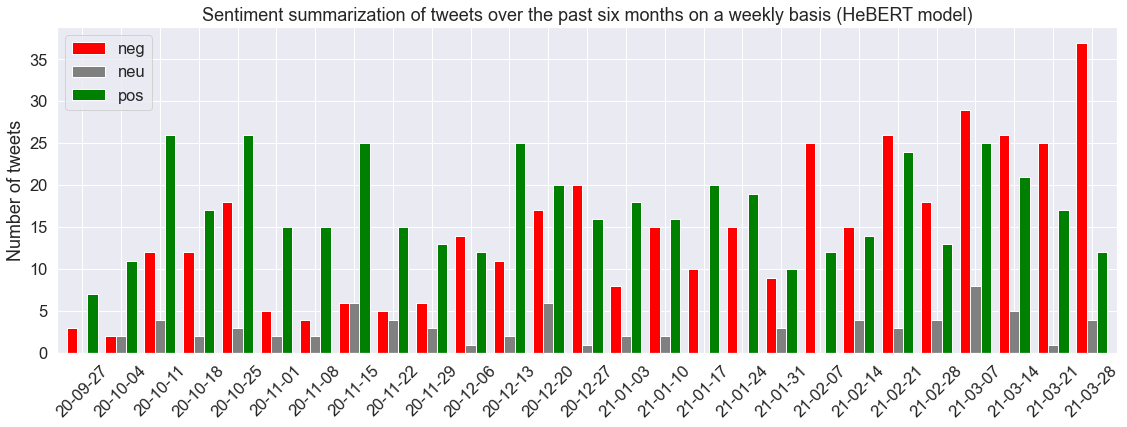

In [83]:
last_6m_sentiment.plot(kind='bar',width=0.8,color=['red','grey','green'] ,figsize=(19,6));
plt.title('Sentiment summarization of tweets over the past six months on a weekly basis (HeBERT model)');
plt.legend(loc="upper left");plt.xticks(rotation=45); plt.ylabel('Number of tweets');plt.xlabel("");

**On a weekly basis for the last four weeks, the amount of tweets with negative sentiment has been higher than the number of tweets with positive sentiment, as seen in the graph.  
It is very interesting to see this phenomenon in light of the fact that the elections in Israel were held on March 23, 2021, and particularly when we see that in almost all the weeks preceding the last month, the positive sentiment outweighed negative sentiment.**

## <u>Topic Modeling</u>

Topic Modeling aims to find the topics (or clusters) inside a corpus of texts, without knowing those topics at first. It's an unsupervised classification technique.  
I'll be using for this task:

#### Gibbs sampling algorithm for a Dirichlet Mixture Model

* Model-based clustering method for short texts.The algorithm iterating across and reassigning clusters using a conditional distribution as a basis. Documents are allocated to clusters based on the highest conditional probability, similar to how the Naive Bayes Classifier functions. It assumes that each short text is generated from single latent topic and use Gibbs sampling technique. The model claims to overcome the short text clustering sparsity problem while still displaying word topics like LDA. 

In [84]:
#First, I'll create a new dataset without tweets that contain less than 5 words.
df_tm = df[df.clean_tweet.str.split().str.len() > 5].copy()

In [85]:
nlp_lemma = spacy_udpipe.load("he") # load Hebrew

def tweet_lemmas(text):
    '''
    Returns Hebrew lemmatize words
    '''
    doc = nlp_lemma(text)
    lemma = [token.lemma_ for token in doc if len(token.lemma_)>1 if token.lemma_ not in he_s_words]
    return lemma

In [86]:
df_tm['lemma_text'] = df_tm['clean_tweet'].apply(tweet_lemmas)

In [87]:
# finding top words (lemmas) in all tweets 
flat_words = [item for sublist in df_tm['lemma_text'] for item in sublist]
word_freq = FreqDist(flat_words).most_common(10)
words_to_extract = [word[0] for word in word_freq if word[1] >500] # 'words that repeats themselves over 500 times 
print(word_freq)

[('◊ô◊©◊®◊ê◊ú', 2318), ('◊õ◊ï◊ú', 1241), ('◊û◊û◊©◊ú◊î', 1090), ('◊û◊ì◊ô◊†◊î', 934), ('◊®◊ê◊©', 570), ('◊©◊ú_', 508), ('◊ê◊ñ◊®◊ó', 492), ('◊ú◊ô◊õ◊ï◊ì', 480), ('◊©◊ú◊ï◊ù', 393), ('◊†◊©◊ô◊ê', 361)]


In [88]:
# Eliminate top words and words below 3 characters to try to help the algorithm refine the clustering.
df_tm['lemma_text'] = df_tm['lemma_text'].apply(lambda x: [word for word in x if word not in words_to_extract and len(word)>2])

In [89]:
docs = df_tm['lemma_text'].tolist()

# GSDMM algorithm
mgp = MovieGroupProcess(K=8, alpha=0.1, beta=0.1, n_iters=20)

vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)
n_docs = len(docs)

# Fit the model
y = mgp.fit(docs, n_terms)

In stage 0: transferred 3478 clusters with 8 clusters populated
In stage 1: transferred 2097 clusters with 8 clusters populated
In stage 2: transferred 1240 clusters with 8 clusters populated
In stage 3: transferred 841 clusters with 8 clusters populated
In stage 4: transferred 672 clusters with 8 clusters populated
In stage 5: transferred 561 clusters with 8 clusters populated
In stage 6: transferred 476 clusters with 8 clusters populated
In stage 7: transferred 435 clusters with 8 clusters populated
In stage 8: transferred 414 clusters with 8 clusters populated
In stage 9: transferred 440 clusters with 8 clusters populated
In stage 10: transferred 390 clusters with 8 clusters populated
In stage 11: transferred 398 clusters with 8 clusters populated
In stage 12: transferred 395 clusters with 8 clusters populated
In stage 13: transferred 410 clusters with 8 clusters populated
In stage 14: transferred 367 clusters with 8 clusters populated
In stage 15: transferred 356 clusters with 8 cl

In [90]:
def top_words(distribution, top_index, num_words):
    '''
    Returns the top words in each cluster based on occources.
    '''
    for topic in top_index:
        pairs = sorted([(k, v) for k, v in distribution[topic].items()], key=lambda x: x[1], reverse=True)
        print(f"Cluster {topic} : {pairs[:num_words]}")
        print('-'*120)

In [91]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topics :', doc_count)
print('*'*70)

# Topics sorted by document inside
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*70)


# Show the top 15 words by cluster, it helps to make the topic_dict below
top_words(mgp.cluster_word_distribution, top_index, 15)

Number of documents per topics : [700 466 353 627 693 729 427 554]
**********************************************************************
Most important clusters (by number of docs inside): [5 0 4 3 7 1 6 2]
**********************************************************************
Cluster 5 : [('◊©◊ú◊ï◊ù', 254), ('◊†◊©◊ô◊ê', 241), ('◊ô◊®◊ï◊©◊ú◊ô◊ù', 113), ('◊ô◊ó◊°◊ô◊ù', 106), ('◊§◊¢◊ï◊ú◊î', 103), ('◊î◊°◊õ◊ù', 96), ('◊©◊ô◊™◊ï◊£', 84), ('◊ó◊©◊ï◊ë', 81), ('◊©◊†◊î', 79), ('◊§◊í◊ô◊©◊î', 73), ('◊ë◊ô◊ß◊ï◊®', 73), ('◊©◊ï◊ó◊ó', 67), ('◊†◊§◊í◊©', 64), ('◊ò◊®◊ê◊û◊§', 64), ('◊™◊ó◊ï◊ù', 59)]
------------------------------------------------------------------------------------------------------------------------
Cluster 0 : [('◊ú◊ô◊õ◊ï◊ì', 349), ('◊î◊¶◊ë◊ô◊¢', 191), ('◊ë◊ó◊ô◊®◊ï◊™', 159), ('◊í◊†◊•', 156), ('◊©◊û◊ê◊ú', 151), ('◊ú◊§◊ô◊ì', 147), ('◊ô◊û◊ô◊ü', 143), ('◊í◊ì◊ï◊ú', 103), ('◊û◊§◊ú◊í◊î', 103), ('◊©◊ô◊ì◊ï◊®', 81), ('◊¢◊õ◊©◊ô◊ï', 71), ('◊û◊ó◊ú', 68), ('◊ó◊ô◊ô◊ë', 64), ('◊ò◊ô◊ë◊ô', 64), ('◊ó◊ñ◊ß', 5

In [93]:
# created by hand so that the topic names refer to the above clusters
topic_dict = {}
topic_names = ['International Affairs',
               'Politics',
               'Health & Economy',
               'National Security',
               'personal allegations',
               'Politics',               
               'Internal Security',
               'Memorials']

for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i]
    

In [94]:
# assign clusters into the dataframe 
df_tm['cluster_name'] = pd.Series([topic_dict[int(x)] for x in y], index=df_tm.index)
df_tm['cluster_number'] = pd.Series(y, index=df_tm.index)
df_tm['cluster_name'].value_counts()

Politics                 1166
International Affairs     729
Health & Economy          693
National Security         627
personal allegations      554
Internal Security         427
Memorials                 353
Name: cluster_name, dtype: int64

**The most reliable method for evaluating unsupervised topic models is still human judgement. However, this takes time and money. I had to look at a few randomly picked tweets in each cluster, much as I had to do with the topic names. 
The results are not perfect, and there might be ways to improve, but as compared to other teqniuqes I tired, GSDMM produced the best results.**

In [95]:
# topic clustering exampls 
for i in set(topic_names):
    display(df_tm[df_tm['cluster_name'] == i][['clean_tweet','cluster_name','cluster_number']].sample(2))

clean_tweet  \
date                                                                                                                                                    
2020-09-28  ◊ê◊ñ◊®◊ó◊ô ◊ô◊©◊®◊ê◊ú ◊ê◊†◊ô ◊í◊ê◊î ◊ë◊¶◊ô◊ë◊ï◊® ◊©◊í◊ô◊ú◊î ◊ê◊ó◊®◊ô◊ï◊™ ◊ï◊©◊û◊® ◊¢◊ú ◊î◊î◊†◊ó◊ô◊ï◊™ ◊ë◊ô◊ï◊ù ◊î◊õ◊ô◊§◊ï◊®◊ô◊ù   ◊ê◊†◊ó◊†◊ï ◊û◊û◊©◊ô◊õ◊ô◊ù ◊ú◊¢◊ë◊ï◊ì ◊û◊°◊ë◊ô◊ë ◊ú◊©◊¢◊ï◊ü ◊õ◊ì◊ô ◊ú◊ë◊ú◊ï◊ù ◊ê◊™ ◊û◊í◊ô◊§◊™ ◊î◊ß◊ï◊®◊ï◊†◊î ◊ë◊ô◊©◊®◊ê◊ú   
2020-11-09                 ◊î◊ï◊®◊ì◊†◊ï ◊ê◊™ ◊î◊™◊ó◊ú◊ï◊ê◊î ◊ë◊ô◊©◊®◊ê◊ú ◊ú◊ê◊ó◊™ ◊î◊®◊û◊ï◊™ ◊î◊†◊û◊ï◊õ◊ï◊™ ◊ë◊¢◊ï◊ú◊ù   ◊õ◊¢◊™ ◊¢◊ú◊ô◊†◊ï ◊ú◊¢◊ë◊ï◊ì ◊ô◊ó◊ì ◊ï◊ú◊©◊û◊ï◊® ◊¢◊ú ◊™◊ó◊ú◊ï◊ê◊î ◊†◊û◊ï◊õ◊î  ◊¢◊ì ◊ú◊î◊í◊¢◊™ ◊î◊ó◊ô◊°◊ï◊†◊ô◊ù ◊ô◊ó◊ì ◊†◊†◊¶◊ó   

                cluster_name  cluster_number  
date                                          
2020-09-28  Health & Economy               4  
2020-11-09  Health & Economy               4

clean_tweet  \
date                                                                                                                                                                                                                                 
2020-03-27                            ◊ê◊†◊ô ◊û◊í◊†◊î ◊ë◊™◊ï◊ß◊£ ◊ê◊™ ◊ê◊ô◊®◊ï◊¢ ◊î◊ê◊ú◊ô◊û◊ï◊™ ◊î◊ó◊û◊ï◊® ◊†◊í◊ì ◊õ◊ï◊ó ◊û◊í◊ë ◊©◊ë◊ï◊¶◊¢ ◊ë◊ú◊ô◊ú◊î ◊õ◊ï◊ó◊ï◊™ ◊î◊ë◊ô◊ò◊ó◊ï◊ü ◊©◊ï◊û◊®◊ô◊ù ◊¢◊ú ◊õ◊ï◊ú◊†◊ï ◊ñ◊î ◊§◊©◊¢ ◊ë◊õ◊ú ◊¢◊™ ◊ê◊ë◊ú ◊§◊©◊¢ ◊õ◊§◊ï◊ú ◊ï◊û◊õ◊ï◊§◊ú ◊ë◊¢◊™ ◊î◊ñ◊ê◊™ ◊õ◊©◊õ◊ï◊ó◊ï◊™ ◊û◊í◊ë ◊ï◊î◊û◊©◊ò◊®◊î ◊û◊°◊ô◊ô◊¢◊ô◊ù ◊ú◊†◊ï ◊ú◊¶◊ú◊ï◊ó ◊ê◊™ ◊û◊©◊ë◊® ◊î◊ß◊ï◊®◊ï◊†◊î   
2020-09-29  ◊û◊ì◊ô◊†◊™ ◊ô◊©◊®◊ê◊ú ◊ñ◊ï◊õ◊®◊™ ◊î◊ô◊ï◊ù ◊ê◊™ ◊ó◊ú◊ú◊ô ◊û◊ú◊ó◊û◊™ ◊ô◊ï◊ù ◊î◊õ◊ô◊§◊ï◊®◊ô◊ù   ◊û◊ú◊ó◊û◊™ ◊ô◊ï◊ù ◊î◊õ◊ô◊§◊ï◊®◊ô◊ù ◊ú◊ô◊û◊ì◊î ◊ê◊ï◊™◊†◊ï ◊©◊ô◊© ◊ë◊†◊ï ◊õ◊ï◊ó◊ï◊™ ◊õ◊ë◊ô◊®◊ô◊ù ◊í◊ù ◊ê◊ù ◊î◊ê◊™◊í◊® ◊ú◊ê ◊ß◊ú ◊í◊ù ◊ê◊ù ◊î◊û◊ê◊ë◊ß ◊¢◊ô◊ß◊© ‚Äì ◊ë◊ô◊õ◊ï◊ú◊™◊†◊ï ◊ú◊î◊©◊ô◊í ◊†◊ô◊¶◊ó◊ï◊ü ◊û◊õ◊®◊ô◊¢   ◊ô◊î◊ô ◊ñ◊õ◊®◊ù ◊©◊ú ◊î◊†◊ï◊§◊ú◊ô◊ù ◊ë◊®◊ï◊ö ◊ï◊†◊¶◊ï◊® ◊ë◊ú◊ô◊ë◊†◊ï ◊ú◊¢◊ì     

                 cluster_name  cluster_number  
date                                           
2020-03-27  Internal Security               6  
2020-09-29  Internal Security               6

clean_tweet  \
date                                                                                                                             
2016-04-06  ◊¢◊ù ◊î◊ß◊ë◊ô◊†◊ò ◊î◊û◊ì◊ô◊†◊ô◊ë◊ô◊ò◊ó◊ï◊†◊ô ◊ë◊°◊ô◊ï◊® ◊ë◊ê◊ï◊í◊ì◊™ ◊ô◊î◊ï◊ì◊î ◊ï◊©◊ï◊û◊®◊ï◊ü ◊î◊†◊ó◊ô◊™◊ô ◊ê◊™ ◊õ◊ï◊ó◊ï◊™◊ô◊†◊ï ◊ú◊î◊û◊©◊ô◊ö ◊ë◊§◊¢◊ô◊ú◊ï◊™ ◊™◊ß◊ô◊§◊î ◊†◊í◊ì ◊î◊ò◊®◊ï◊®  ◊ú◊ú◊ê ◊û◊í◊ë◊ú◊ï◊™     
2017-09-19                                                    ◊ë◊ú◊û◊¢◊ú◊î ◊û ◊©◊†◊ï◊™ ◊î◊ô◊õ◊®◊ï◊™◊ô ◊¢◊ù ◊î◊ê◊ï◊¥◊ù ◊ú◊ê ◊©◊û◊¢◊™◊ô ◊†◊ê◊ï◊ù ◊ô◊ï◊™◊® ◊ê◊û◊ô◊• ◊ï◊ô◊ï◊™◊® ◊ó◊ì    

                 cluster_name  cluster_number  
date                                           
2016-04-06  National Security               3  
2017-09-19  National Security               3

clean_tweet  \
date                                                                                                                                                                                                                                                                                 
2019-09-02  ◊õ◊ú ◊§◊¢◊ï◊ú◊ï◊™◊ô◊ï ◊©◊ú ◊®◊ê◊© ◊î◊û◊û◊©◊ú◊î ◊™◊ï◊ê◊û◊ï◊™ ◊ú◊ó◊ú◊ï◊ò◊ô◊ü ◊ê◊™ ◊î◊†◊ó◊ô◊ï◊™ ◊î◊ô◊ï◊¢◊û◊¥◊© ◊ú◊ê◊ó◊® ◊©◊¢◊ñ◊ë ◊ê◊™ ◊™◊§◊ß◊ô◊ì◊ï ◊õ◊©◊® ◊î◊™◊ß◊©◊ï◊®◊™ ◊õ◊ö ◊õ◊™◊ë ◊î◊ô◊ï◊¢◊û◊¥◊© ◊¥◊†◊™◊†◊ô◊î◊ï ◊®◊©◊ê◊ô ◊ú◊¢◊°◊ï◊ß ◊ë◊¢◊†◊ô◊ô◊†◊ô◊ù ◊î◊†◊ï◊í◊¢◊ô◊ù ◊ú◊û◊©◊®◊ì◊ô ◊î◊û◊û◊©◊ú◊î ◊î◊©◊ï◊†◊ô◊ù ◊ï◊î◊¢◊ï◊ë◊ì◊î ◊©◊î◊ï◊ê ◊ê◊ô◊†◊ï ◊û◊õ◊î◊ü ◊¢◊ï◊ì ◊õ◊©◊® ◊î◊™◊ß◊©◊ï◊®◊™ ◊ê◊ô◊†◊î ◊©◊ï◊ú◊ú◊™ ◊¢◊ï◊ì ◊ê◊™ ◊û◊¢◊ï◊®◊ë◊ï◊™◊ï ◊ë◊™◊ó◊ï◊ù ◊î◊™◊ß◊©◊ï◊®◊™ ◊ë◊õ◊ï◊ë◊¢◊ï ◊õ◊®◊ê◊© ◊î◊û◊û◊©◊ú◊î◊¥   
2019-09-19                                                                       ◊ê◊ó◊®◊ô ◊©◊ó◊ì◊©◊ï◊™  ◊í◊†◊• ◊ò◊ô◊ï◊ô ◊†◊ô◊°◊ï ◊ú◊î◊©◊§◊ô◊¢ ◊¢◊ú ◊î◊ë◊ó◊ô◊®◊ï◊™ ◊õ◊¢◊™ ◊î◊ù ◊û◊†◊°◊ô◊ù ◊ú◊î◊©◊§◊ô◊¢ ◊¢◊ú ◊î◊©◊ô◊û◊ï◊¢ ◊î◊¢◊®◊ë ◊î◊ù ◊©◊ï◊ë ◊î◊ó◊ú◊ô◊ò◊ï ◊©◊ú◊ê ◊ú◊©◊ì◊® ◊ê◊™ ◊™◊í◊ï◊ë◊™◊†◊ï ◊ñ◊ê◊™ ◊î◊™◊í◊ï◊ë◊î ◊ú◊©◊ß◊®◊ô◊ù ◊©◊ú◊î◊ù  ◊¢◊ï◊ì ◊ô◊ì◊ô◊¢◊î ◊©◊¢◊®◊ï◊õ◊î ◊ë◊ê◊ï◊§◊ü ◊û◊í◊û◊™◊ô ◊©◊ê◊ô◊ü ◊ë◊î ◊õ◊ú◊ï◊ù ◊û◊°◊¢ ◊î◊¶◊ô◊ì ◊†◊û◊©◊ö   

                    cluster_name  cluster_number  
date                                              
2019-09-02  personal allegations               7  
2019-09-19  personal allegations               7

clean_tweet  \
date                                                                                                                                                                                                   
2020-08-15  ◊ê◊†◊ô ◊û◊ë◊ô◊¢ ◊¶◊¢◊® ◊¢◊û◊ï◊ß ◊¢◊ú ◊§◊ò◊ô◊®◊™◊î ◊©◊ú ◊§◊®◊ï◊§◊°◊ï◊® ◊®◊ï◊™ ◊í◊ë◊ô◊ñ◊ï◊ü ◊õ◊ú◊™ ◊§◊®◊° ◊ô◊©◊®◊ê◊ú ◊ï◊û◊î◊ì◊û◊ï◊ô◊ï◊™ ◊î◊ë◊õ◊ô◊®◊ï◊™ ◊ë◊¢◊ï◊ú◊ù ◊î◊û◊©◊§◊ò ◊ë◊ô◊©◊®◊ê◊ú   ◊ß◊ï◊ú◊î ◊î◊ô◊ô◊ó◊ï◊ì◊ô ◊©◊ú ◊§◊®◊ï◊§◊≥ ◊í◊ë◊ô◊ñ◊ï◊ü ◊†◊©◊û◊¢ ◊ë◊ê◊ï◊§◊ü ◊®◊ù ◊ï◊ë◊®◊ï◊® ◊í◊ù ◊õ◊©◊ú◊ê ◊î◊ô◊î ◊û◊ß◊ï◊ë◊ú ◊ê◊ï ◊ë◊ß◊ï◊†◊¶◊†◊ñ◊ï◊°     
2015-02-11                                                                                                                   ◊î◊†◊î ◊î◊ì◊ë◊®◊ô◊ù ◊©◊ê◊û◊®◊™◊ô ◊î◊ô◊ï◊ù ◊ú◊™◊ú◊û◊ô◊ì◊ô ◊î◊û◊õ◊ô◊†◊î ◊î◊ß◊ì◊ù ◊¶◊ë◊ê◊ô◊™ ◊ë◊†◊ô ◊ì◊ï◊ì ◊©◊ë◊ô◊ô◊©◊ï◊ë ◊¢◊ú◊ô      

           cluster_name  cluster_number  
date                                     
2020-08-15    Memorials               2  
2015-02-11    Memorials               2

clean_tweet  \
date                                                                                            
2019-09-10     ◊†◊ë◊ô◊ê ◊ê◊™ ◊ó◊ï◊ß ◊î◊û◊¶◊ú◊û◊ï◊™ ◊û◊ó◊® ◊ú◊î◊¶◊ë◊¢◊î ◊ë◊õ◊†◊°◊™ ◊õ◊ì◊ô ◊©◊†◊ï◊õ◊ú ◊ú◊ì◊¢◊™ ◊û◊ô ◊ë◊¢◊ì ◊ñ◊ô◊ï◊£ ◊ß◊ú◊§◊ô◊ï◊™ ◊ï◊û◊ô ◊†◊í◊ì   
2020-05-12  ◊ê◊†◊ô ◊®◊ï◊¶◊î ◊ê◊™ ◊õ◊ú ◊í◊ï◊© ◊î◊ô◊û◊ô◊ü ◊ë◊ß◊ï◊ê◊ú◊ô◊¶◊ô◊î ◊ú◊û◊î ◊ô◊û◊ô◊†◊î ◊¢◊ì◊ô◊ô◊ü ◊û◊™◊¢◊ß◊©◊™ ◊ú◊î◊ô◊©◊ê◊® ◊ë◊ê◊ï◊§◊ï◊ñ◊ô◊¶◊ô◊î ◊¶◊§◊ï     

           cluster_name  cluster_number  
date                                     
2019-09-10     Politics               0  
2020-05-12     Politics               0

clean_tweet  \
date                                                                                                                                                                                                                                               
2020-09-12  ◊ñ◊î ◊û◊¶◊ò◊®◊£ ◊ú◊î◊°◊õ◊ù ◊î◊©◊ú◊ï◊ù ◊î◊î◊ô◊°◊ò◊ï◊®◊ô ◊¢◊ù ◊ê◊ô◊ó◊ï◊ì ◊î◊ê◊û◊ô◊®◊ï◊ô◊ï◊™ ◊ñ◊î ◊ú◊ß◊ó ◊ú◊†◊ï  ◊©◊†◊ô◊ù ◊ú◊î◊í◊ô◊¢ ◊û◊î◊°◊õ◊ù ◊î◊©◊ú◊ï◊ù ◊î◊©◊†◊ô ◊¢◊ù ◊û◊ì◊ô◊†◊î ◊¢◊®◊ë◊ô◊™ ◊ú◊î◊°◊õ◊ù ◊î◊©◊ú◊ï◊ù ◊î◊©◊ú◊ô◊©◊ô ◊ï◊ñ◊î ◊ú◊ß◊ó ◊ú◊†◊ï ◊ú◊ê  ◊©◊†◊ô◊ù ◊ê◊ú◊ê  ◊ô◊ï◊ù ◊ú◊î◊í◊ô◊¢ ◊ú◊î◊°◊õ◊ù ◊î◊©◊ú◊ï◊ù ◊ë◊ô◊ü ◊î◊û◊ì◊ô◊†◊î ◊î◊¢◊®◊ë◊ô◊™ ◊î◊©◊ú◊ô◊©◊ô◊™ ◊ú◊û◊ì◊ô◊†◊î ◊î◊¢◊®◊ë◊ô◊™ ◊î◊®◊ë◊ô◊¢◊ô◊™ ◊ï◊ô◊î◊ô◊ï ◊¢◊ï◊ì   
2017-12-03                                                                                              ◊û◊î◊§◊ö ◊¢◊†◊ß ◊ë◊ô◊ó◊°◊ô ◊î◊ó◊ï◊• ◊©◊ú ◊ô◊©◊®◊ê◊ú ◊ë ◊û◊™◊ï◊ö  ◊û◊ì◊ô◊†◊ï◊™ ◊ë◊¢◊ï◊ú◊ù ◊®◊ï◊ë ◊î◊ê◊ñ◊®◊ó◊ô◊ù ◊û◊ê◊û◊ô◊†◊ô◊ù ◊©◊û◊ì◊ô◊†◊ï◊™◊ô◊î◊ù ◊ô◊®◊ï◊ï◊ô◊ó◊ï ◊û◊î◊ß◊©◊® ◊¢◊ù ◊ô◊©◊®◊ê◊ú ◊û◊ì◊ô◊†◊™ ◊ô◊©◊®◊ê◊ú ◊î◊ô◊ê ◊õ◊ï◊ó ◊¢◊ï◊ú◊û◊ô ◊¢◊ï◊ú◊î     

                     cluster_name  cluster_number  
date                                               
2020-09-12  International Affairs               5  
2017-12-03  International Affairs               5

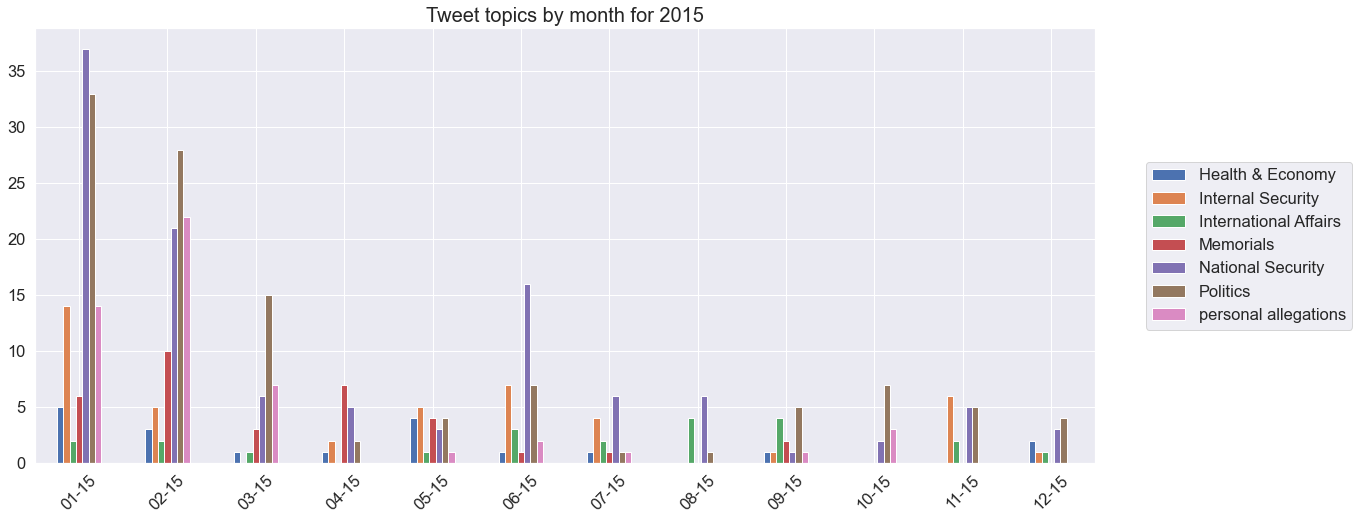

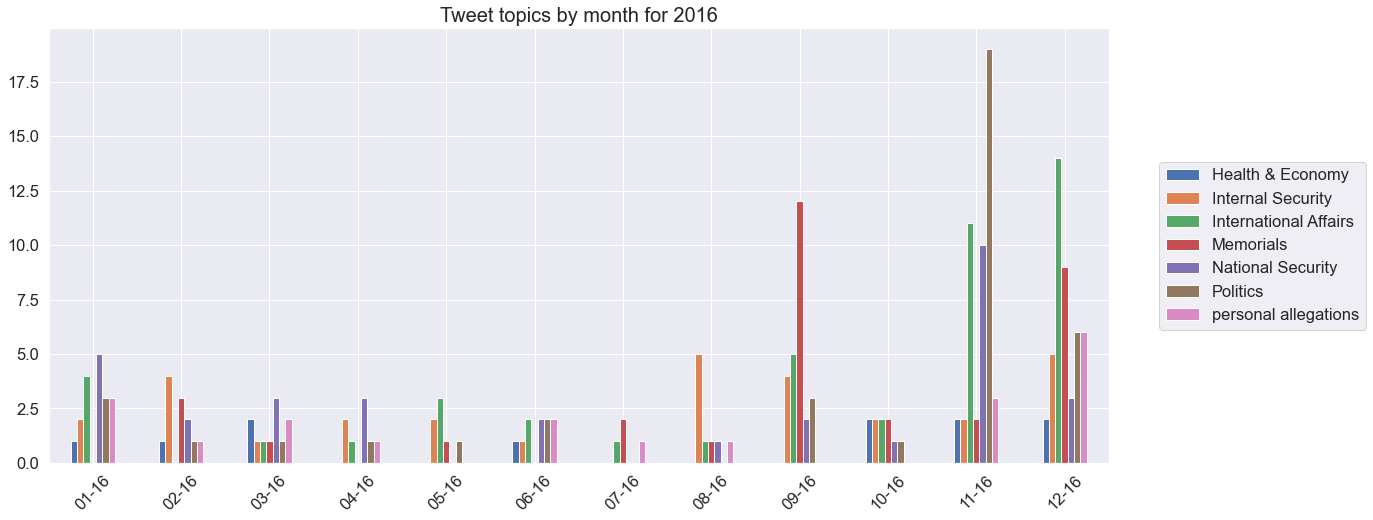

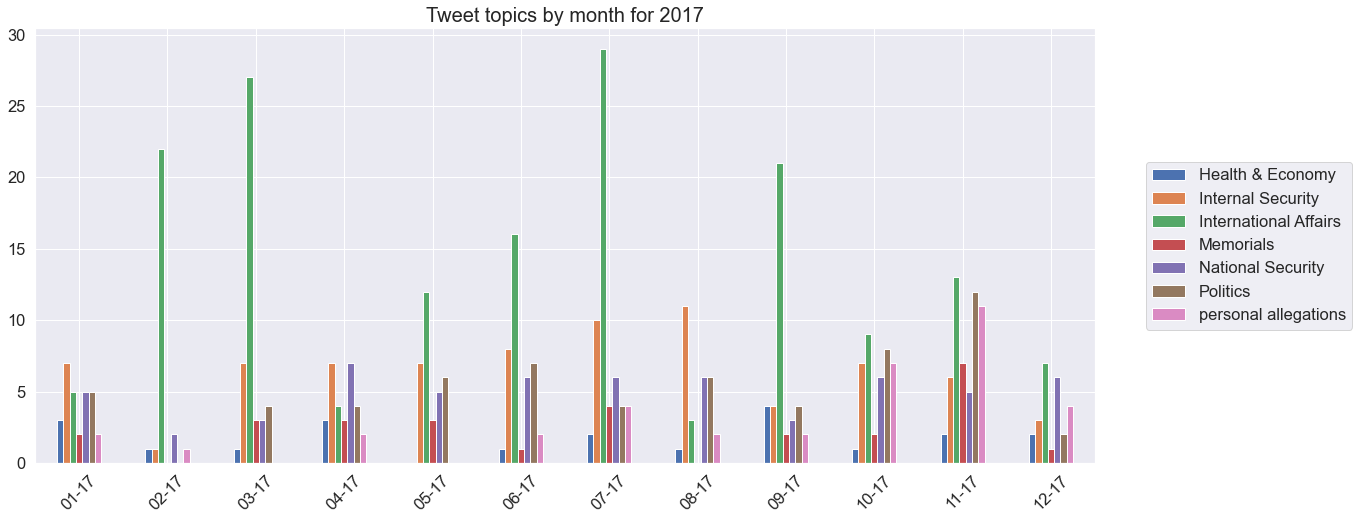

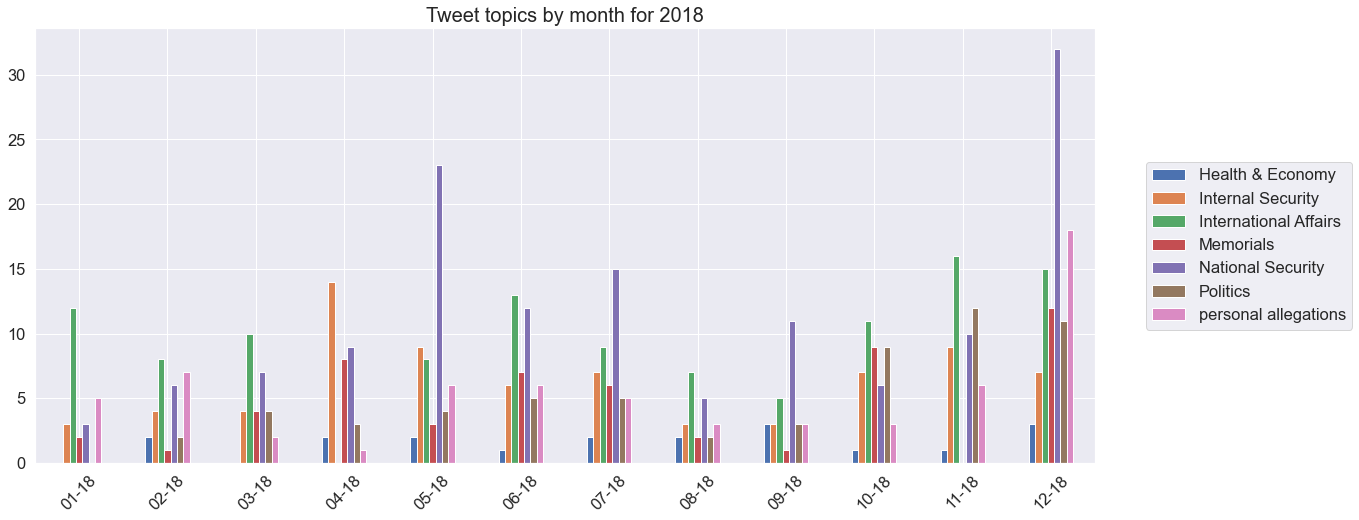

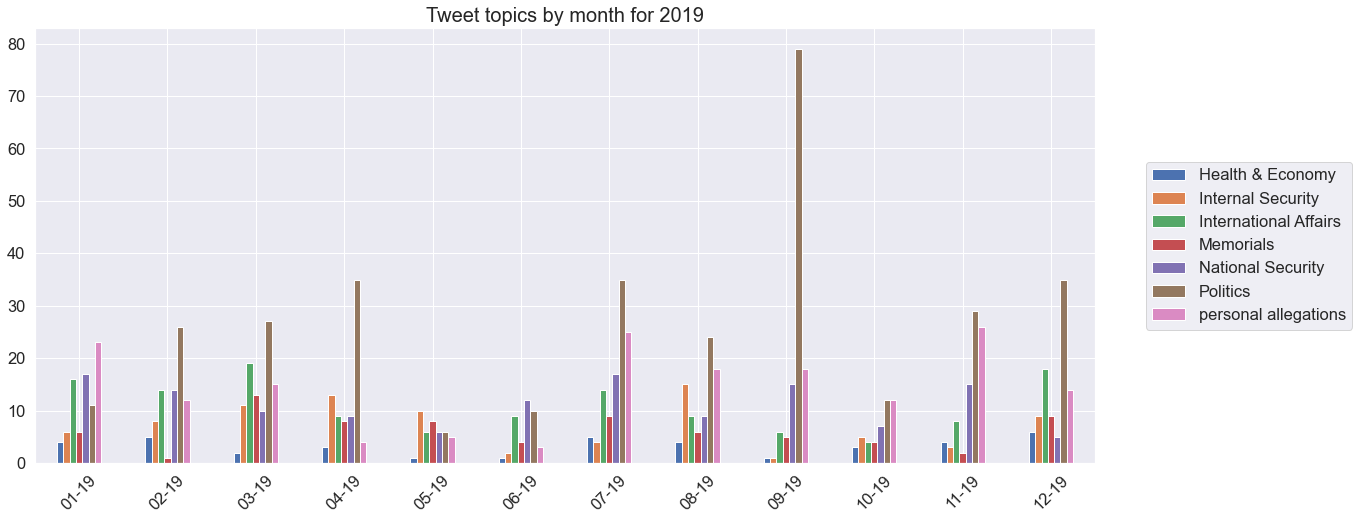

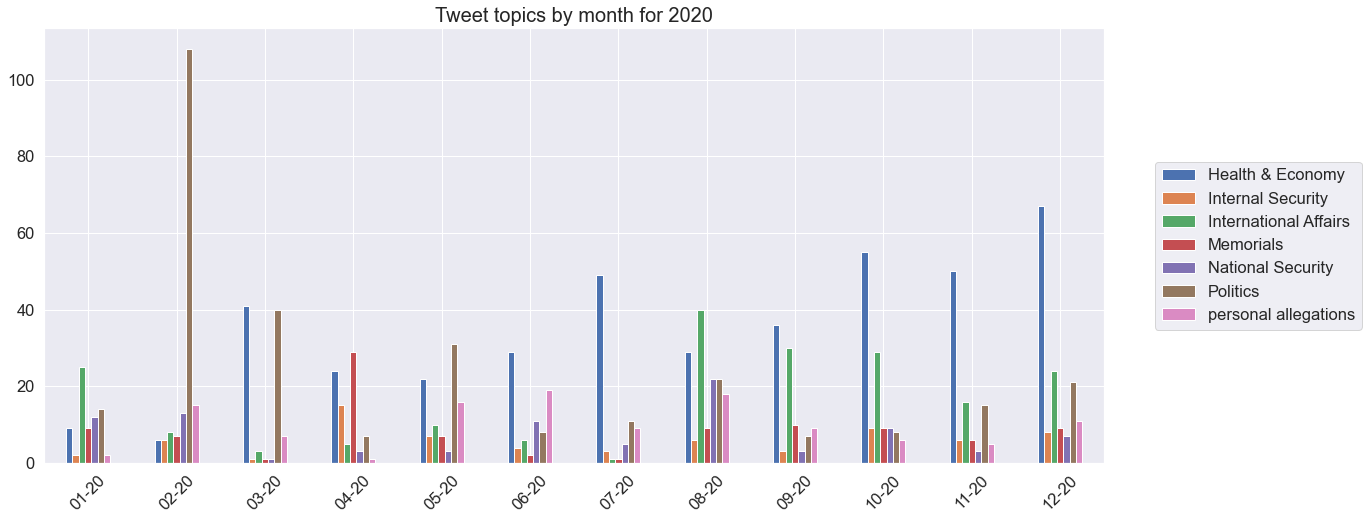

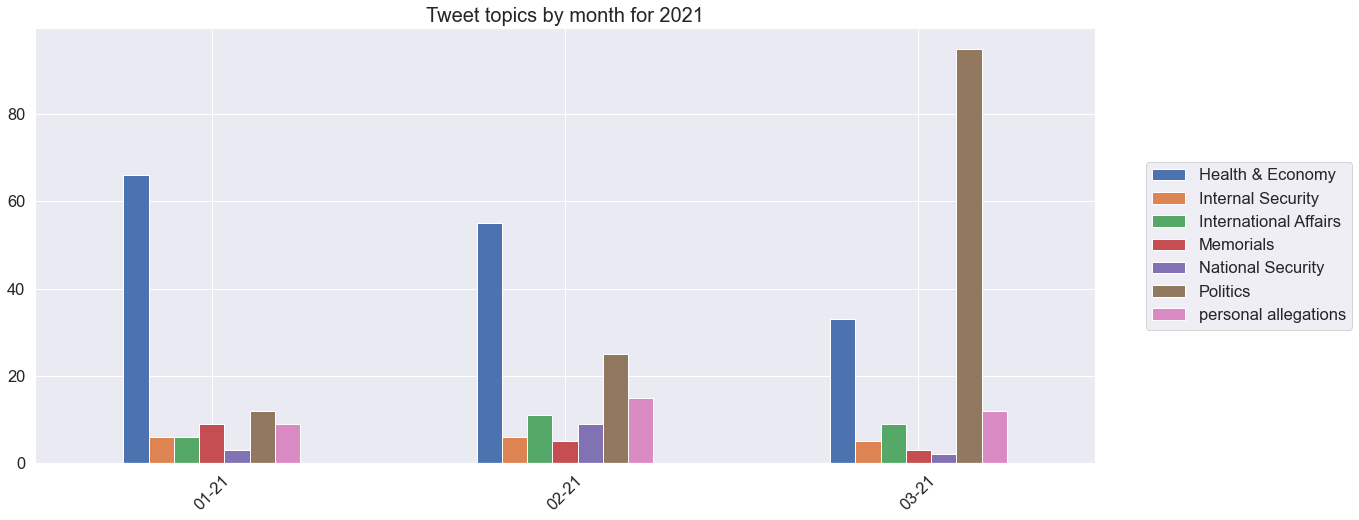

In [96]:
# tweet topics on monthly basis for each year since 2015
for i in range(2015,2022):
    df_gsdmm = df_tm[str(i)].resample('M').cluster_name.value_counts().unstack().fillna(0)
    df_gsdmm.index = df_gsdmm.index.strftime('%m-%y')
    df_gsdmm.plot(kind='bar',figsize=(19,8));
    plt.title(f'Tweet topics by month for {i}', size=20);plt.xlabel("")
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left");plt.xticks(rotation=45);